In [129]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.utils import to_categorical
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

import numpy as np
# https://github.com/eriklindernoren/Keras-GAN

In [130]:
def trainClassif():
    (train_set, train_label_raw), (_, _) = mnist.load_data()
    train_label = to_categorical(train_label_raw)
    train_data = np.asarray(train_set).reshape(60000, 28, 28, 1)
    X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.33, random_state=43)

#     test_data = test_set.reshape(10000, 28, 28, 1)

    np.shape(train_data)

    model = Sequential()
    # model.add(Conv2D(5, kernel_size=3, activation='relu', input_shape=(28,28,1)))
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    # model.add(Conv2D(32, kernel_size=3, activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # model.summary()

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)
    return model

In [131]:
classif = trainClassif()

Train on 40200 samples, validate on 19800 samples
Epoch 1/3
40200/40200 [==============================] - 13s 326us/step - loss: 11.2838 - acc: 0.2981 - val_loss: 11.2767 - val_acc: 0.2980
Epoch 2/3
40200/40200 [==============================] - 10s 251us/step - loss: 11.2211 - acc: 0.3031 - val_loss: 11.1985 - val_acc: 0.3049
Epoch 3/3
40200/40200 [==============================] - 10s 245us/step - loss: 11.2155 - acc: 0.3036 - val_loss: 11.2223 - val_acc: 0.3034


In [132]:
class CGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Configure input
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()
        
    def generate_images(self, num):
        r, c = 2, 5
        arr_imgs = []
        arr_labels = []
        for i in range(0, num):
            noise = np.random.normal(0, 1, (2 * 5, 100))
            sampled_labels = np.arange(0, 10).reshape(-1, 1)
            gen_imgs = self.generator.predict([noise, sampled_labels])

            # Rescale images 0 - 1
            gen_imgs = 0.5 * gen_imgs + 0.5
            arr_imgs.append(gen_imgs)
            arr_labels.append(sampled_labels)
            
        out_imgs = np.asarray(arr_imgs).reshape(num*10, 28, 28, 1)
        out_labels = np.asarray(arr_labels).reshape(num*10, 1)
        
        return out_imgs, out_labels

In [141]:

cgan = CGAN()
cgan.train(epochs=10001, batch_size=128, sample_interval=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_111 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_79 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_80 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_113 (Dense)            (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_81 (LeakyReLU)   (None, 512)               0         
__________

90 [D loss: 0.515104, acc.: 73.44%] [G loss: 3.544746]
91 [D loss: 0.534793, acc.: 73.44%] [G loss: 3.304272]
92 [D loss: 0.470620, acc.: 75.39%] [G loss: 3.463522]
93 [D loss: 0.480530, acc.: 75.39%] [G loss: 2.915488]
94 [D loss: 0.528735, acc.: 68.36%] [G loss: 3.051752]
95 [D loss: 0.499245, acc.: 75.78%] [G loss: 3.171541]
96 [D loss: 0.570818, acc.: 67.19%] [G loss: 3.306067]
97 [D loss: 0.551906, acc.: 67.58%] [G loss: 3.093795]
98 [D loss: 0.541785, acc.: 68.75%] [G loss: 2.951324]
99 [D loss: 0.468410, acc.: 74.22%] [G loss: 3.247274]
100 [D loss: 0.543661, acc.: 71.09%] [G loss: 2.939031]
101 [D loss: 0.520411, acc.: 72.27%] [G loss: 2.792660]
102 [D loss: 0.562292, acc.: 66.80%] [G loss: 2.749533]
103 [D loss: 0.546642, acc.: 70.31%] [G loss: 2.959979]
104 [D loss: 0.445426, acc.: 76.17%] [G loss: 3.055482]
105 [D loss: 0.492804, acc.: 75.00%] [G loss: 2.628506]
106 [D loss: 0.624300, acc.: 60.94%] [G loss: 2.685003]
107 [D loss: 0.578445, acc.: 65.23%] [G loss: 2.982125]
10

237 [D loss: 0.654451, acc.: 56.64%] [G loss: 1.349622]
238 [D loss: 0.629843, acc.: 58.59%] [G loss: 1.705906]
239 [D loss: 0.613629, acc.: 62.11%] [G loss: 1.360872]
240 [D loss: 0.680731, acc.: 53.12%] [G loss: 1.324060]
241 [D loss: 0.614802, acc.: 59.38%] [G loss: 1.504758]
242 [D loss: 0.648433, acc.: 55.86%] [G loss: 1.354700]
243 [D loss: 0.646075, acc.: 61.72%] [G loss: 1.324909]
244 [D loss: 0.617473, acc.: 62.11%] [G loss: 1.337174]
245 [D loss: 0.637409, acc.: 57.42%] [G loss: 1.293631]
246 [D loss: 0.652352, acc.: 57.42%] [G loss: 1.627519]
247 [D loss: 0.660405, acc.: 56.25%] [G loss: 1.308213]
248 [D loss: 0.645179, acc.: 58.20%] [G loss: 1.299366]
249 [D loss: 0.615087, acc.: 58.98%] [G loss: 1.500324]
250 [D loss: 0.634472, acc.: 58.20%] [G loss: 1.541221]
251 [D loss: 0.623023, acc.: 63.67%] [G loss: 1.316829]
252 [D loss: 0.644545, acc.: 60.16%] [G loss: 1.476683]
253 [D loss: 0.650334, acc.: 59.77%] [G loss: 1.292233]
254 [D loss: 0.642468, acc.: 61.33%] [G loss: 1.

388 [D loss: 0.614635, acc.: 67.97%] [G loss: 1.064363]
389 [D loss: 0.622146, acc.: 66.02%] [G loss: 1.084909]
390 [D loss: 0.620321, acc.: 67.58%] [G loss: 1.168852]
391 [D loss: 0.625301, acc.: 69.92%] [G loss: 1.111859]
392 [D loss: 0.608576, acc.: 67.58%] [G loss: 1.171529]
393 [D loss: 0.624642, acc.: 64.06%] [G loss: 1.144887]
394 [D loss: 0.608830, acc.: 68.75%] [G loss: 1.063350]
395 [D loss: 0.618787, acc.: 63.28%] [G loss: 0.999311]
396 [D loss: 0.599744, acc.: 70.31%] [G loss: 1.104869]
397 [D loss: 0.625445, acc.: 66.80%] [G loss: 1.186676]
398 [D loss: 0.619329, acc.: 70.31%] [G loss: 1.104243]
399 [D loss: 0.630042, acc.: 62.11%] [G loss: 1.127717]
400 [D loss: 0.622276, acc.: 66.80%] [G loss: 1.062271]
401 [D loss: 0.628167, acc.: 68.36%] [G loss: 1.025047]
402 [D loss: 0.634301, acc.: 67.97%] [G loss: 1.043695]
403 [D loss: 0.655647, acc.: 63.67%] [G loss: 1.095321]
404 [D loss: 0.620887, acc.: 62.50%] [G loss: 1.075965]
405 [D loss: 0.625122, acc.: 64.45%] [G loss: 1.

535 [D loss: 0.630893, acc.: 58.20%] [G loss: 1.076423]
536 [D loss: 0.622244, acc.: 63.67%] [G loss: 0.960859]
537 [D loss: 0.636408, acc.: 62.50%] [G loss: 1.058491]
538 [D loss: 0.627047, acc.: 60.94%] [G loss: 1.052510]
539 [D loss: 0.622091, acc.: 57.42%] [G loss: 1.040033]
540 [D loss: 0.679118, acc.: 52.73%] [G loss: 1.025758]
541 [D loss: 0.639583, acc.: 61.72%] [G loss: 1.067892]
542 [D loss: 0.629938, acc.: 60.94%] [G loss: 1.000324]
543 [D loss: 0.630189, acc.: 63.28%] [G loss: 1.034063]
544 [D loss: 0.695708, acc.: 48.83%] [G loss: 1.034033]
545 [D loss: 0.622112, acc.: 63.67%] [G loss: 1.016629]
546 [D loss: 0.673088, acc.: 53.12%] [G loss: 1.079804]
547 [D loss: 0.644865, acc.: 59.38%] [G loss: 1.053209]
548 [D loss: 0.692161, acc.: 51.95%] [G loss: 1.080377]
549 [D loss: 0.672866, acc.: 55.47%] [G loss: 1.091726]
550 [D loss: 0.682509, acc.: 58.20%] [G loss: 0.980228]
551 [D loss: 0.672231, acc.: 57.03%] [G loss: 1.034693]
552 [D loss: 0.656002, acc.: 52.73%] [G loss: 1.

682 [D loss: 0.698206, acc.: 50.00%] [G loss: 0.968238]
683 [D loss: 0.680451, acc.: 53.91%] [G loss: 0.927561]
684 [D loss: 0.655352, acc.: 62.50%] [G loss: 0.895292]
685 [D loss: 0.660038, acc.: 60.16%] [G loss: 0.913999]
686 [D loss: 0.672820, acc.: 56.25%] [G loss: 0.950124]
687 [D loss: 0.688131, acc.: 53.91%] [G loss: 0.881362]
688 [D loss: 0.668781, acc.: 57.03%] [G loss: 0.937568]
689 [D loss: 0.693622, acc.: 49.61%] [G loss: 0.922515]
690 [D loss: 0.701291, acc.: 52.34%] [G loss: 0.950948]
691 [D loss: 0.661172, acc.: 56.25%] [G loss: 0.963095]
692 [D loss: 0.681582, acc.: 48.44%] [G loss: 0.941677]
693 [D loss: 0.689933, acc.: 48.44%] [G loss: 0.901295]
694 [D loss: 0.654277, acc.: 59.38%] [G loss: 0.896948]
695 [D loss: 0.680286, acc.: 56.64%] [G loss: 0.925086]
696 [D loss: 0.686928, acc.: 51.17%] [G loss: 0.886834]
697 [D loss: 0.665118, acc.: 54.69%] [G loss: 0.876528]
698 [D loss: 0.664548, acc.: 55.08%] [G loss: 0.887576]
699 [D loss: 0.687067, acc.: 55.08%] [G loss: 1.

830 [D loss: 0.691592, acc.: 52.34%] [G loss: 0.895280]
831 [D loss: 0.678456, acc.: 55.86%] [G loss: 0.880757]
832 [D loss: 0.661761, acc.: 59.38%] [G loss: 0.874006]
833 [D loss: 0.666981, acc.: 55.86%] [G loss: 0.970410]
834 [D loss: 0.681369, acc.: 57.81%] [G loss: 0.910493]
835 [D loss: 0.664742, acc.: 58.20%] [G loss: 0.884538]
836 [D loss: 0.681061, acc.: 53.91%] [G loss: 0.871202]
837 [D loss: 0.649633, acc.: 58.59%] [G loss: 0.929887]
838 [D loss: 0.649335, acc.: 58.98%] [G loss: 0.877795]
839 [D loss: 0.665139, acc.: 58.59%] [G loss: 0.908217]
840 [D loss: 0.658166, acc.: 57.42%] [G loss: 0.924290]
841 [D loss: 0.665247, acc.: 52.73%] [G loss: 0.890666]
842 [D loss: 0.683998, acc.: 50.39%] [G loss: 0.926630]
843 [D loss: 0.672312, acc.: 51.56%] [G loss: 0.895273]
844 [D loss: 0.667232, acc.: 58.59%] [G loss: 0.883017]
845 [D loss: 0.683911, acc.: 50.39%] [G loss: 0.924421]
846 [D loss: 0.686321, acc.: 52.73%] [G loss: 0.925094]
847 [D loss: 0.683989, acc.: 50.39%] [G loss: 0.

980 [D loss: 0.692181, acc.: 52.34%] [G loss: 0.859618]
981 [D loss: 0.697315, acc.: 48.83%] [G loss: 0.843859]
982 [D loss: 0.671800, acc.: 57.42%] [G loss: 0.909510]
983 [D loss: 0.692107, acc.: 53.91%] [G loss: 0.842264]
984 [D loss: 0.715151, acc.: 51.56%] [G loss: 0.816023]
985 [D loss: 0.696622, acc.: 56.25%] [G loss: 0.832359]
986 [D loss: 0.689768, acc.: 54.69%] [G loss: 0.842652]
987 [D loss: 0.687906, acc.: 50.39%] [G loss: 0.833626]
988 [D loss: 0.688868, acc.: 52.34%] [G loss: 0.834514]
989 [D loss: 0.677285, acc.: 55.86%] [G loss: 0.814408]
990 [D loss: 0.698457, acc.: 50.00%] [G loss: 0.846245]
991 [D loss: 0.701342, acc.: 50.00%] [G loss: 0.826474]
992 [D loss: 0.676842, acc.: 59.38%] [G loss: 0.819464]
993 [D loss: 0.675784, acc.: 55.08%] [G loss: 0.835662]
994 [D loss: 0.680625, acc.: 57.03%] [G loss: 0.861255]
995 [D loss: 0.665055, acc.: 60.55%] [G loss: 0.851437]
996 [D loss: 0.676119, acc.: 57.81%] [G loss: 0.849096]
997 [D loss: 0.684684, acc.: 52.73%] [G loss: 0.

1126 [D loss: 0.675626, acc.: 55.47%] [G loss: 0.810781]
1127 [D loss: 0.695609, acc.: 52.73%] [G loss: 0.842432]
1128 [D loss: 0.688782, acc.: 55.86%] [G loss: 0.817437]
1129 [D loss: 0.682072, acc.: 55.08%] [G loss: 0.792793]
1130 [D loss: 0.690597, acc.: 55.47%] [G loss: 0.799139]
1131 [D loss: 0.689301, acc.: 53.12%] [G loss: 0.812060]
1132 [D loss: 0.695068, acc.: 53.12%] [G loss: 0.805110]
1133 [D loss: 0.679388, acc.: 58.59%] [G loss: 0.793434]
1134 [D loss: 0.675167, acc.: 55.08%] [G loss: 0.786933]
1135 [D loss: 0.679776, acc.: 55.47%] [G loss: 0.796422]
1136 [D loss: 0.684289, acc.: 54.69%] [G loss: 0.818097]
1137 [D loss: 0.684036, acc.: 51.17%] [G loss: 0.842176]
1138 [D loss: 0.666326, acc.: 57.03%] [G loss: 0.803646]
1139 [D loss: 0.689030, acc.: 50.78%] [G loss: 0.795269]
1140 [D loss: 0.679649, acc.: 54.30%] [G loss: 0.812053]
1141 [D loss: 0.695138, acc.: 53.91%] [G loss: 0.823801]
1142 [D loss: 0.695633, acc.: 55.08%] [G loss: 0.818259]
1143 [D loss: 0.692133, acc.: 5

1270 [D loss: 0.675079, acc.: 55.47%] [G loss: 0.801494]
1271 [D loss: 0.694845, acc.: 50.00%] [G loss: 0.785123]
1272 [D loss: 0.685088, acc.: 51.95%] [G loss: 0.812590]
1273 [D loss: 0.675468, acc.: 60.16%] [G loss: 0.781511]
1274 [D loss: 0.688797, acc.: 57.81%] [G loss: 0.790320]
1275 [D loss: 0.678820, acc.: 52.73%] [G loss: 0.810437]
1276 [D loss: 0.689537, acc.: 52.73%] [G loss: 0.807887]
1277 [D loss: 0.671930, acc.: 54.69%] [G loss: 0.775879]
1278 [D loss: 0.679890, acc.: 54.30%] [G loss: 0.803356]
1279 [D loss: 0.710728, acc.: 43.36%] [G loss: 0.792724]
1280 [D loss: 0.689033, acc.: 51.17%] [G loss: 0.818385]
1281 [D loss: 0.680065, acc.: 55.47%] [G loss: 0.797235]
1282 [D loss: 0.680826, acc.: 55.08%] [G loss: 0.796246]
1283 [D loss: 0.680986, acc.: 57.42%] [G loss: 0.783302]
1284 [D loss: 0.672141, acc.: 58.98%] [G loss: 0.787657]
1285 [D loss: 0.682428, acc.: 54.30%] [G loss: 0.776272]
1286 [D loss: 0.677510, acc.: 57.03%] [G loss: 0.775345]
1287 [D loss: 0.683046, acc.: 5

1414 [D loss: 0.690839, acc.: 53.12%] [G loss: 0.763502]
1415 [D loss: 0.696028, acc.: 49.22%] [G loss: 0.771514]
1416 [D loss: 0.688880, acc.: 59.77%] [G loss: 0.763107]
1417 [D loss: 0.682791, acc.: 53.52%] [G loss: 0.769325]
1418 [D loss: 0.707071, acc.: 50.39%] [G loss: 0.759604]
1419 [D loss: 0.701310, acc.: 47.66%] [G loss: 0.750962]
1420 [D loss: 0.695175, acc.: 51.17%] [G loss: 0.765122]
1421 [D loss: 0.675476, acc.: 61.72%] [G loss: 0.758681]
1422 [D loss: 0.693487, acc.: 53.52%] [G loss: 0.762227]
1423 [D loss: 0.691102, acc.: 53.52%] [G loss: 0.772323]
1424 [D loss: 0.694059, acc.: 48.83%] [G loss: 0.768229]
1425 [D loss: 0.687850, acc.: 53.12%] [G loss: 0.781090]
1426 [D loss: 0.703284, acc.: 50.00%] [G loss: 0.791711]
1427 [D loss: 0.689762, acc.: 53.91%] [G loss: 0.767256]
1428 [D loss: 0.685346, acc.: 54.69%] [G loss: 0.761650]
1429 [D loss: 0.681241, acc.: 58.59%] [G loss: 0.773448]
1430 [D loss: 0.693303, acc.: 48.05%] [G loss: 0.769771]
1431 [D loss: 0.690808, acc.: 5

1559 [D loss: 0.685914, acc.: 57.42%] [G loss: 0.763097]
1560 [D loss: 0.687146, acc.: 51.17%] [G loss: 0.781551]
1561 [D loss: 0.681522, acc.: 54.30%] [G loss: 0.785941]
1562 [D loss: 0.662660, acc.: 62.50%] [G loss: 0.778889]
1563 [D loss: 0.685506, acc.: 55.08%] [G loss: 0.762563]
1564 [D loss: 0.676787, acc.: 55.08%] [G loss: 0.758645]
1565 [D loss: 0.682506, acc.: 54.30%] [G loss: 0.769308]
1566 [D loss: 0.677474, acc.: 58.59%] [G loss: 0.755697]
1567 [D loss: 0.684984, acc.: 56.64%] [G loss: 0.769857]
1568 [D loss: 0.684598, acc.: 56.25%] [G loss: 0.779946]
1569 [D loss: 0.681948, acc.: 53.52%] [G loss: 0.774651]
1570 [D loss: 0.674169, acc.: 54.69%] [G loss: 0.775871]
1571 [D loss: 0.693915, acc.: 51.95%] [G loss: 0.773806]
1572 [D loss: 0.682803, acc.: 50.78%] [G loss: 0.753268]
1573 [D loss: 0.693340, acc.: 54.30%] [G loss: 0.761020]
1574 [D loss: 0.689527, acc.: 59.38%] [G loss: 0.770617]
1575 [D loss: 0.671248, acc.: 57.03%] [G loss: 0.755335]
1576 [D loss: 0.677872, acc.: 5

1704 [D loss: 0.680722, acc.: 57.03%] [G loss: 0.775171]
1705 [D loss: 0.680479, acc.: 58.59%] [G loss: 0.807379]
1706 [D loss: 0.680222, acc.: 56.64%] [G loss: 0.771947]
1707 [D loss: 0.691293, acc.: 48.83%] [G loss: 0.783023]
1708 [D loss: 0.680476, acc.: 57.81%] [G loss: 0.779597]
1709 [D loss: 0.684715, acc.: 56.25%] [G loss: 0.793244]
1710 [D loss: 0.678151, acc.: 53.91%] [G loss: 0.801800]
1711 [D loss: 0.686819, acc.: 53.12%] [G loss: 0.778884]
1712 [D loss: 0.670281, acc.: 57.42%] [G loss: 0.777625]
1713 [D loss: 0.688365, acc.: 53.52%] [G loss: 0.782497]
1714 [D loss: 0.674715, acc.: 58.98%] [G loss: 0.791196]
1715 [D loss: 0.667953, acc.: 55.08%] [G loss: 0.784430]
1716 [D loss: 0.685446, acc.: 54.30%] [G loss: 0.765363]
1717 [D loss: 0.684183, acc.: 51.95%] [G loss: 0.790293]
1718 [D loss: 0.678437, acc.: 54.69%] [G loss: 0.792629]
1719 [D loss: 0.687900, acc.: 58.20%] [G loss: 0.790227]
1720 [D loss: 0.686294, acc.: 54.30%] [G loss: 0.778672]
1721 [D loss: 0.684268, acc.: 5

1848 [D loss: 0.691219, acc.: 52.73%] [G loss: 0.803641]
1849 [D loss: 0.672008, acc.: 56.64%] [G loss: 0.808502]
1850 [D loss: 0.686862, acc.: 54.30%] [G loss: 0.797000]
1851 [D loss: 0.673477, acc.: 55.47%] [G loss: 0.815814]
1852 [D loss: 0.694306, acc.: 50.39%] [G loss: 0.773668]
1853 [D loss: 0.673419, acc.: 56.64%] [G loss: 0.804581]
1854 [D loss: 0.680576, acc.: 53.52%] [G loss: 0.816507]
1855 [D loss: 0.694872, acc.: 51.17%] [G loss: 0.801232]
1856 [D loss: 0.688299, acc.: 51.17%] [G loss: 0.792487]
1857 [D loss: 0.678261, acc.: 57.42%] [G loss: 0.807655]
1858 [D loss: 0.688840, acc.: 53.12%] [G loss: 0.806006]
1859 [D loss: 0.672695, acc.: 56.25%] [G loss: 0.811658]
1860 [D loss: 0.677882, acc.: 55.08%] [G loss: 0.810200]
1861 [D loss: 0.687897, acc.: 53.91%] [G loss: 0.779338]
1862 [D loss: 0.682434, acc.: 52.34%] [G loss: 0.804849]
1863 [D loss: 0.676216, acc.: 57.42%] [G loss: 0.798586]
1864 [D loss: 0.684211, acc.: 55.08%] [G loss: 0.804545]
1865 [D loss: 0.683203, acc.: 5

1994 [D loss: 0.678144, acc.: 57.81%] [G loss: 0.784792]
1995 [D loss: 0.670039, acc.: 54.69%] [G loss: 0.773788]
1996 [D loss: 0.679116, acc.: 53.91%] [G loss: 0.758306]
1997 [D loss: 0.682913, acc.: 55.47%] [G loss: 0.776432]
1998 [D loss: 0.684133, acc.: 55.86%] [G loss: 0.787436]
1999 [D loss: 0.682752, acc.: 49.22%] [G loss: 0.778871]
2000 [D loss: 0.673778, acc.: 58.20%] [G loss: 0.784326]
2001 [D loss: 0.696621, acc.: 53.91%] [G loss: 0.793516]
2002 [D loss: 0.683464, acc.: 49.61%] [G loss: 0.756794]
2003 [D loss: 0.684366, acc.: 52.73%] [G loss: 0.792925]
2004 [D loss: 0.677369, acc.: 55.86%] [G loss: 0.767211]
2005 [D loss: 0.689512, acc.: 48.83%] [G loss: 0.805315]
2006 [D loss: 0.685697, acc.: 52.73%] [G loss: 0.782187]
2007 [D loss: 0.684689, acc.: 50.78%] [G loss: 0.760317]
2008 [D loss: 0.709182, acc.: 50.00%] [G loss: 0.742506]
2009 [D loss: 0.689016, acc.: 55.08%] [G loss: 0.766514]
2010 [D loss: 0.677473, acc.: 53.91%] [G loss: 0.788366]
2011 [D loss: 0.693901, acc.: 5

2143 [D loss: 0.697610, acc.: 49.61%] [G loss: 0.803133]
2144 [D loss: 0.676167, acc.: 58.20%] [G loss: 0.764811]
2145 [D loss: 0.698196, acc.: 50.78%] [G loss: 0.748900]
2146 [D loss: 0.690709, acc.: 53.52%] [G loss: 0.748637]
2147 [D loss: 0.679893, acc.: 49.61%] [G loss: 0.754660]
2148 [D loss: 0.670119, acc.: 55.08%] [G loss: 0.744386]
2149 [D loss: 0.694103, acc.: 50.78%] [G loss: 0.780070]
2150 [D loss: 0.693454, acc.: 50.78%] [G loss: 0.773822]
2151 [D loss: 0.688475, acc.: 52.34%] [G loss: 0.772790]
2152 [D loss: 0.673393, acc.: 57.81%] [G loss: 0.768352]
2153 [D loss: 0.682710, acc.: 56.64%] [G loss: 0.753406]
2154 [D loss: 0.685566, acc.: 53.12%] [G loss: 0.756757]
2155 [D loss: 0.677170, acc.: 57.03%] [G loss: 0.757011]
2156 [D loss: 0.699744, acc.: 53.12%] [G loss: 0.744366]
2157 [D loss: 0.707598, acc.: 50.00%] [G loss: 0.770712]
2158 [D loss: 0.678042, acc.: 53.12%] [G loss: 0.766598]
2159 [D loss: 0.684525, acc.: 56.25%] [G loss: 0.749442]
2160 [D loss: 0.678123, acc.: 5

2288 [D loss: 0.688251, acc.: 51.95%] [G loss: 0.748244]
2289 [D loss: 0.689402, acc.: 49.61%] [G loss: 0.795295]
2290 [D loss: 0.687593, acc.: 51.56%] [G loss: 0.781326]
2291 [D loss: 0.680626, acc.: 51.95%] [G loss: 0.829355]
2292 [D loss: 0.684829, acc.: 51.95%] [G loss: 0.766314]
2293 [D loss: 0.682305, acc.: 51.56%] [G loss: 0.773120]
2294 [D loss: 0.677794, acc.: 54.30%] [G loss: 0.779488]
2295 [D loss: 0.680963, acc.: 48.05%] [G loss: 0.770732]
2296 [D loss: 0.686980, acc.: 49.22%] [G loss: 0.767152]
2297 [D loss: 0.670879, acc.: 57.03%] [G loss: 0.750460]
2298 [D loss: 0.688108, acc.: 52.34%] [G loss: 0.767555]
2299 [D loss: 0.675279, acc.: 53.12%] [G loss: 0.757716]
2300 [D loss: 0.673786, acc.: 52.73%] [G loss: 0.775148]
2301 [D loss: 0.669622, acc.: 57.42%] [G loss: 0.781420]
2302 [D loss: 0.681379, acc.: 52.73%] [G loss: 0.760256]
2303 [D loss: 0.662734, acc.: 58.98%] [G loss: 0.755485]
2304 [D loss: 0.674753, acc.: 55.86%] [G loss: 0.776986]
2305 [D loss: 0.676738, acc.: 5

2435 [D loss: 0.680608, acc.: 50.00%] [G loss: 0.759204]
2436 [D loss: 0.670932, acc.: 58.98%] [G loss: 0.741993]
2437 [D loss: 0.682467, acc.: 54.69%] [G loss: 0.771256]
2438 [D loss: 0.652283, acc.: 60.16%] [G loss: 0.756374]
2439 [D loss: 0.655690, acc.: 57.42%] [G loss: 0.778586]
2440 [D loss: 0.681081, acc.: 52.34%] [G loss: 0.737460]
2441 [D loss: 0.670085, acc.: 54.30%] [G loss: 0.772705]
2442 [D loss: 0.672502, acc.: 52.34%] [G loss: 0.775715]
2443 [D loss: 0.683490, acc.: 50.78%] [G loss: 0.768187]
2444 [D loss: 0.674142, acc.: 56.64%] [G loss: 0.764240]
2445 [D loss: 0.677495, acc.: 52.34%] [G loss: 0.765803]
2446 [D loss: 0.664517, acc.: 60.16%] [G loss: 0.757465]
2447 [D loss: 0.674151, acc.: 49.61%] [G loss: 0.775541]
2448 [D loss: 0.672058, acc.: 55.47%] [G loss: 0.799449]
2449 [D loss: 0.681611, acc.: 52.73%] [G loss: 0.752119]
2450 [D loss: 0.684209, acc.: 55.47%] [G loss: 0.763069]
2451 [D loss: 0.667073, acc.: 55.08%] [G loss: 0.757762]
2452 [D loss: 0.671050, acc.: 5

2580 [D loss: 0.674482, acc.: 54.30%] [G loss: 0.774735]
2581 [D loss: 0.686378, acc.: 51.95%] [G loss: 0.819413]
2582 [D loss: 0.681178, acc.: 52.34%] [G loss: 0.776736]
2583 [D loss: 0.685356, acc.: 55.86%] [G loss: 0.769355]
2584 [D loss: 0.675165, acc.: 57.03%] [G loss: 0.780717]
2585 [D loss: 0.669237, acc.: 57.42%] [G loss: 0.790752]
2586 [D loss: 0.685399, acc.: 51.17%] [G loss: 0.780754]
2587 [D loss: 0.681890, acc.: 54.30%] [G loss: 0.808127]
2588 [D loss: 0.668252, acc.: 55.47%] [G loss: 0.771472]
2589 [D loss: 0.692622, acc.: 50.00%] [G loss: 0.765341]
2590 [D loss: 0.685196, acc.: 51.95%] [G loss: 0.772423]
2591 [D loss: 0.673670, acc.: 57.42%] [G loss: 0.767823]
2592 [D loss: 0.668663, acc.: 57.42%] [G loss: 0.753682]
2593 [D loss: 0.687567, acc.: 53.52%] [G loss: 0.777002]
2594 [D loss: 0.683487, acc.: 53.91%] [G loss: 0.777213]
2595 [D loss: 0.665632, acc.: 59.38%] [G loss: 0.806881]
2596 [D loss: 0.673753, acc.: 55.08%] [G loss: 0.759455]
2597 [D loss: 0.688818, acc.: 5

2727 [D loss: 0.668476, acc.: 57.42%] [G loss: 0.778474]
2728 [D loss: 0.666524, acc.: 55.47%] [G loss: 0.779458]
2729 [D loss: 0.660290, acc.: 56.64%] [G loss: 0.847651]
2730 [D loss: 0.669045, acc.: 54.30%] [G loss: 0.767774]
2731 [D loss: 0.676596, acc.: 51.95%] [G loss: 0.766319]
2732 [D loss: 0.678849, acc.: 55.86%] [G loss: 0.754609]
2733 [D loss: 0.673401, acc.: 53.52%] [G loss: 0.755941]
2734 [D loss: 0.674878, acc.: 55.47%] [G loss: 0.756725]
2735 [D loss: 0.687663, acc.: 49.61%] [G loss: 0.774892]
2736 [D loss: 0.686289, acc.: 51.95%] [G loss: 0.772327]
2737 [D loss: 0.677355, acc.: 51.56%] [G loss: 0.770952]
2738 [D loss: 0.655779, acc.: 58.20%] [G loss: 0.775195]
2739 [D loss: 0.684003, acc.: 50.39%] [G loss: 0.779639]
2740 [D loss: 0.670141, acc.: 58.98%] [G loss: 0.765646]
2741 [D loss: 0.694484, acc.: 51.17%] [G loss: 0.769025]
2742 [D loss: 0.658904, acc.: 58.59%] [G loss: 0.759841]
2743 [D loss: 0.694989, acc.: 52.73%] [G loss: 0.768733]
2744 [D loss: 0.682372, acc.: 5

2872 [D loss: 0.675783, acc.: 57.81%] [G loss: 0.791040]
2873 [D loss: 0.696476, acc.: 48.83%] [G loss: 0.779404]
2874 [D loss: 0.685942, acc.: 52.34%] [G loss: 0.755785]
2875 [D loss: 0.661818, acc.: 55.86%] [G loss: 0.761122]
2876 [D loss: 0.702262, acc.: 54.30%] [G loss: 0.762342]
2877 [D loss: 0.679159, acc.: 54.30%] [G loss: 0.781467]
2878 [D loss: 0.695571, acc.: 52.73%] [G loss: 0.757019]
2879 [D loss: 0.677358, acc.: 55.86%] [G loss: 0.742823]
2880 [D loss: 0.694382, acc.: 50.00%] [G loss: 0.777447]
2881 [D loss: 0.689292, acc.: 53.52%] [G loss: 0.754361]
2882 [D loss: 0.683119, acc.: 53.91%] [G loss: 0.762593]
2883 [D loss: 0.698749, acc.: 48.44%] [G loss: 0.754973]
2884 [D loss: 0.674526, acc.: 53.52%] [G loss: 0.773423]
2885 [D loss: 0.688319, acc.: 50.78%] [G loss: 0.765851]
2886 [D loss: 0.698833, acc.: 51.56%] [G loss: 0.746533]
2887 [D loss: 0.688810, acc.: 51.95%] [G loss: 0.762278]
2888 [D loss: 0.666378, acc.: 58.98%] [G loss: 0.813231]
2889 [D loss: 0.677299, acc.: 5

3020 [D loss: 0.680609, acc.: 53.52%] [G loss: 0.745055]
3021 [D loss: 0.696088, acc.: 55.47%] [G loss: 0.765331]
3022 [D loss: 0.674983, acc.: 57.03%] [G loss: 0.767963]
3023 [D loss: 0.683645, acc.: 53.12%] [G loss: 0.808127]
3024 [D loss: 0.683947, acc.: 54.30%] [G loss: 0.774569]
3025 [D loss: 0.688730, acc.: 53.91%] [G loss: 0.775108]
3026 [D loss: 0.686698, acc.: 53.91%] [G loss: 0.781052]
3027 [D loss: 0.672036, acc.: 58.98%] [G loss: 0.793545]
3028 [D loss: 0.676395, acc.: 51.56%] [G loss: 0.771614]
3029 [D loss: 0.680518, acc.: 53.91%] [G loss: 0.792089]
3030 [D loss: 0.682973, acc.: 52.34%] [G loss: 0.769959]
3031 [D loss: 0.673167, acc.: 57.03%] [G loss: 0.773179]
3032 [D loss: 0.691512, acc.: 53.52%] [G loss: 0.769698]
3033 [D loss: 0.673095, acc.: 58.59%] [G loss: 0.751984]
3034 [D loss: 0.679838, acc.: 54.30%] [G loss: 0.776334]
3035 [D loss: 0.679133, acc.: 50.78%] [G loss: 0.787403]
3036 [D loss: 0.682438, acc.: 51.95%] [G loss: 0.800476]
3037 [D loss: 0.680966, acc.: 5

3164 [D loss: 0.683944, acc.: 53.12%] [G loss: 0.782307]
3165 [D loss: 0.677477, acc.: 57.42%] [G loss: 0.774326]
3166 [D loss: 0.679844, acc.: 56.25%] [G loss: 0.789507]
3167 [D loss: 0.672038, acc.: 58.59%] [G loss: 0.808772]
3168 [D loss: 0.678499, acc.: 50.00%] [G loss: 0.797609]
3169 [D loss: 0.694591, acc.: 51.95%] [G loss: 0.773712]
3170 [D loss: 0.682148, acc.: 52.34%] [G loss: 0.785018]
3171 [D loss: 0.674010, acc.: 53.52%] [G loss: 0.761712]
3172 [D loss: 0.644935, acc.: 58.20%] [G loss: 0.798032]
3173 [D loss: 0.674881, acc.: 53.91%] [G loss: 0.774581]
3174 [D loss: 0.667951, acc.: 55.08%] [G loss: 0.795961]
3175 [D loss: 0.688351, acc.: 52.34%] [G loss: 0.777309]
3176 [D loss: 0.681660, acc.: 56.25%] [G loss: 0.771586]
3177 [D loss: 0.667746, acc.: 53.91%] [G loss: 0.801389]
3178 [D loss: 0.658010, acc.: 64.84%] [G loss: 0.804585]
3179 [D loss: 0.671435, acc.: 55.86%] [G loss: 0.769808]
3180 [D loss: 0.659056, acc.: 60.16%] [G loss: 0.786533]
3181 [D loss: 0.673095, acc.: 5

3308 [D loss: 0.674458, acc.: 56.64%] [G loss: 0.780175]
3309 [D loss: 0.680136, acc.: 54.30%] [G loss: 0.762135]
3310 [D loss: 0.680930, acc.: 57.03%] [G loss: 0.746368]
3311 [D loss: 0.675508, acc.: 53.91%] [G loss: 0.777416]
3312 [D loss: 0.676591, acc.: 55.08%] [G loss: 0.794651]
3313 [D loss: 0.672952, acc.: 56.25%] [G loss: 0.753811]
3314 [D loss: 0.684334, acc.: 57.42%] [G loss: 0.757087]
3315 [D loss: 0.679809, acc.: 57.81%] [G loss: 0.771382]
3316 [D loss: 0.677877, acc.: 51.17%] [G loss: 0.767672]
3317 [D loss: 0.683910, acc.: 54.69%] [G loss: 0.769930]
3318 [D loss: 0.686028, acc.: 56.64%] [G loss: 0.747429]
3319 [D loss: 0.681766, acc.: 53.52%] [G loss: 0.750503]
3320 [D loss: 0.671287, acc.: 54.30%] [G loss: 0.767978]
3321 [D loss: 0.680659, acc.: 58.98%] [G loss: 0.760392]
3322 [D loss: 0.674206, acc.: 53.91%] [G loss: 0.762974]
3323 [D loss: 0.669654, acc.: 51.56%] [G loss: 0.765808]
3324 [D loss: 0.667208, acc.: 55.47%] [G loss: 0.773415]
3325 [D loss: 0.672817, acc.: 5

3455 [D loss: 0.680333, acc.: 52.73%] [G loss: 0.777565]
3456 [D loss: 0.659596, acc.: 56.64%] [G loss: 0.815433]
3457 [D loss: 0.677702, acc.: 54.69%] [G loss: 0.778861]
3458 [D loss: 0.668756, acc.: 56.25%] [G loss: 0.761810]
3459 [D loss: 0.683030, acc.: 54.69%] [G loss: 0.788405]
3460 [D loss: 0.665568, acc.: 58.20%] [G loss: 0.761379]
3461 [D loss: 0.681677, acc.: 50.00%] [G loss: 0.784326]
3462 [D loss: 0.692128, acc.: 51.17%] [G loss: 0.795276]
3463 [D loss: 0.675927, acc.: 54.69%] [G loss: 0.790503]
3464 [D loss: 0.684667, acc.: 53.12%] [G loss: 0.780585]
3465 [D loss: 0.676315, acc.: 49.61%] [G loss: 0.761313]
3466 [D loss: 0.709310, acc.: 50.39%] [G loss: 0.782041]
3467 [D loss: 0.663247, acc.: 58.59%] [G loss: 0.764136]
3468 [D loss: 0.679394, acc.: 57.03%] [G loss: 0.764414]
3469 [D loss: 0.669464, acc.: 51.56%] [G loss: 0.767346]
3470 [D loss: 0.678869, acc.: 53.52%] [G loss: 0.786077]
3471 [D loss: 0.677790, acc.: 50.00%] [G loss: 0.767975]
3472 [D loss: 0.687081, acc.: 5

3600 [D loss: 0.670176, acc.: 58.59%] [G loss: 0.750790]
3601 [D loss: 0.689992, acc.: 54.69%] [G loss: 0.755109]
3602 [D loss: 0.696846, acc.: 49.61%] [G loss: 0.774518]
3603 [D loss: 0.673606, acc.: 51.56%] [G loss: 0.756177]
3604 [D loss: 0.690390, acc.: 53.12%] [G loss: 0.770363]
3605 [D loss: 0.673173, acc.: 57.42%] [G loss: 0.765696]
3606 [D loss: 0.684844, acc.: 53.91%] [G loss: 0.743330]
3607 [D loss: 0.684176, acc.: 51.95%] [G loss: 0.762805]
3608 [D loss: 0.691114, acc.: 50.39%] [G loss: 0.770516]
3609 [D loss: 0.684447, acc.: 53.12%] [G loss: 0.769826]
3610 [D loss: 0.681901, acc.: 54.69%] [G loss: 0.756263]
3611 [D loss: 0.679455, acc.: 57.81%] [G loss: 0.754648]
3612 [D loss: 0.680034, acc.: 52.34%] [G loss: 0.748244]
3613 [D loss: 0.683739, acc.: 52.34%] [G loss: 0.766540]
3614 [D loss: 0.684845, acc.: 50.78%] [G loss: 0.772936]
3615 [D loss: 0.678358, acc.: 58.98%] [G loss: 0.739876]
3616 [D loss: 0.684602, acc.: 50.00%] [G loss: 0.751892]
3617 [D loss: 0.699107, acc.: 5

3748 [D loss: 0.678229, acc.: 53.91%] [G loss: 0.736067]
3749 [D loss: 0.685857, acc.: 52.34%] [G loss: 0.774452]
3750 [D loss: 0.676299, acc.: 55.47%] [G loss: 0.751926]
3751 [D loss: 0.688434, acc.: 56.64%] [G loss: 0.751482]
3752 [D loss: 0.683942, acc.: 49.61%] [G loss: 0.759717]
3753 [D loss: 0.676087, acc.: 57.03%] [G loss: 0.750933]
3754 [D loss: 0.680446, acc.: 55.08%] [G loss: 0.737629]
3755 [D loss: 0.680990, acc.: 57.42%] [G loss: 0.712313]
3756 [D loss: 0.676743, acc.: 53.12%] [G loss: 0.751103]
3757 [D loss: 0.686980, acc.: 52.34%] [G loss: 0.779387]
3758 [D loss: 0.680918, acc.: 57.81%] [G loss: 0.752115]
3759 [D loss: 0.663839, acc.: 60.94%] [G loss: 0.730353]
3760 [D loss: 0.686463, acc.: 50.39%] [G loss: 0.744979]
3761 [D loss: 0.673241, acc.: 57.03%] [G loss: 0.744674]
3762 [D loss: 0.696601, acc.: 51.17%] [G loss: 0.746770]
3763 [D loss: 0.680135, acc.: 53.91%] [G loss: 0.787009]
3764 [D loss: 0.685630, acc.: 51.56%] [G loss: 0.749621]
3765 [D loss: 0.687333, acc.: 5

3895 [D loss: 0.683296, acc.: 51.56%] [G loss: 0.765717]
3896 [D loss: 0.690729, acc.: 57.03%] [G loss: 0.746119]
3897 [D loss: 0.680497, acc.: 54.69%] [G loss: 0.745532]
3898 [D loss: 0.686813, acc.: 52.34%] [G loss: 0.758953]
3899 [D loss: 0.683121, acc.: 50.39%] [G loss: 0.759843]
3900 [D loss: 0.696191, acc.: 49.22%] [G loss: 0.745831]
3901 [D loss: 0.685292, acc.: 53.52%] [G loss: 0.757400]
3902 [D loss: 0.686109, acc.: 51.95%] [G loss: 0.744851]
3903 [D loss: 0.683964, acc.: 54.30%] [G loss: 0.744227]
3904 [D loss: 0.675797, acc.: 58.20%] [G loss: 0.749985]
3905 [D loss: 0.693453, acc.: 50.39%] [G loss: 0.745521]
3906 [D loss: 0.694603, acc.: 53.91%] [G loss: 0.753852]
3907 [D loss: 0.688526, acc.: 57.03%] [G loss: 0.734661]
3908 [D loss: 0.690674, acc.: 54.30%] [G loss: 0.754897]
3909 [D loss: 0.691391, acc.: 52.34%] [G loss: 0.755295]
3910 [D loss: 0.690097, acc.: 50.39%] [G loss: 0.740463]
3911 [D loss: 0.675129, acc.: 53.91%] [G loss: 0.743478]
3912 [D loss: 0.683334, acc.: 5

4042 [D loss: 0.676875, acc.: 51.17%] [G loss: 0.751612]
4043 [D loss: 0.680704, acc.: 58.59%] [G loss: 0.747223]
4044 [D loss: 0.688444, acc.: 56.25%] [G loss: 0.740875]
4045 [D loss: 0.676313, acc.: 51.95%] [G loss: 0.767902]
4046 [D loss: 0.686453, acc.: 52.73%] [G loss: 0.749382]
4047 [D loss: 0.685024, acc.: 52.34%] [G loss: 0.753315]
4048 [D loss: 0.681285, acc.: 55.86%] [G loss: 0.748905]
4049 [D loss: 0.682795, acc.: 54.30%] [G loss: 0.731002]
4050 [D loss: 0.692528, acc.: 57.81%] [G loss: 0.743325]
4051 [D loss: 0.679371, acc.: 56.25%] [G loss: 0.742384]
4052 [D loss: 0.672846, acc.: 58.20%] [G loss: 0.740697]
4053 [D loss: 0.683229, acc.: 51.17%] [G loss: 0.727627]
4054 [D loss: 0.689581, acc.: 51.95%] [G loss: 0.729551]
4055 [D loss: 0.695850, acc.: 53.91%] [G loss: 0.726909]
4056 [D loss: 0.693035, acc.: 53.91%] [G loss: 0.751754]
4057 [D loss: 0.689348, acc.: 52.34%] [G loss: 0.735435]
4058 [D loss: 0.690424, acc.: 54.69%] [G loss: 0.737518]
4059 [D loss: 0.684139, acc.: 5

4188 [D loss: 0.695188, acc.: 50.39%] [G loss: 0.759592]
4189 [D loss: 0.686014, acc.: 48.83%] [G loss: 0.762642]
4190 [D loss: 0.689676, acc.: 54.30%] [G loss: 0.743871]
4191 [D loss: 0.684610, acc.: 51.17%] [G loss: 0.744567]
4192 [D loss: 0.688191, acc.: 57.03%] [G loss: 0.745620]
4193 [D loss: 0.678660, acc.: 56.64%] [G loss: 0.764072]
4194 [D loss: 0.684784, acc.: 53.12%] [G loss: 0.751025]
4195 [D loss: 0.694476, acc.: 53.12%] [G loss: 0.744004]
4196 [D loss: 0.693459, acc.: 52.34%] [G loss: 0.751003]
4197 [D loss: 0.687989, acc.: 52.34%] [G loss: 0.743010]
4198 [D loss: 0.698350, acc.: 46.88%] [G loss: 0.767666]
4199 [D loss: 0.680134, acc.: 54.30%] [G loss: 0.740890]
4200 [D loss: 0.678128, acc.: 55.86%] [G loss: 0.746548]
4201 [D loss: 0.695498, acc.: 48.44%] [G loss: 0.734671]
4202 [D loss: 0.680539, acc.: 53.91%] [G loss: 0.758942]
4203 [D loss: 0.694819, acc.: 50.39%] [G loss: 0.753051]
4204 [D loss: 0.685470, acc.: 57.81%] [G loss: 0.750193]
4205 [D loss: 0.687655, acc.: 5

4332 [D loss: 0.683969, acc.: 55.47%] [G loss: 0.764929]
4333 [D loss: 0.679284, acc.: 49.22%] [G loss: 0.752733]
4334 [D loss: 0.678833, acc.: 56.25%] [G loss: 0.747803]
4335 [D loss: 0.681466, acc.: 57.03%] [G loss: 0.766061]
4336 [D loss: 0.667147, acc.: 54.69%] [G loss: 0.759701]
4337 [D loss: 0.681516, acc.: 50.78%] [G loss: 0.757222]
4338 [D loss: 0.679982, acc.: 57.03%] [G loss: 0.746701]
4339 [D loss: 0.687494, acc.: 53.91%] [G loss: 0.763975]
4340 [D loss: 0.682424, acc.: 55.08%] [G loss: 0.747571]
4341 [D loss: 0.687707, acc.: 54.69%] [G loss: 0.756018]
4342 [D loss: 0.677121, acc.: 55.86%] [G loss: 0.747519]
4343 [D loss: 0.670461, acc.: 58.20%] [G loss: 0.749551]
4344 [D loss: 0.672849, acc.: 55.08%] [G loss: 0.752964]
4345 [D loss: 0.682262, acc.: 58.98%] [G loss: 0.751139]
4346 [D loss: 0.687038, acc.: 51.56%] [G loss: 0.747575]
4347 [D loss: 0.678986, acc.: 55.47%] [G loss: 0.754396]
4348 [D loss: 0.670257, acc.: 57.42%] [G loss: 0.739554]
4349 [D loss: 0.687703, acc.: 5

4481 [D loss: 0.687828, acc.: 55.47%] [G loss: 0.773846]
4482 [D loss: 0.678918, acc.: 51.95%] [G loss: 0.763284]
4483 [D loss: 0.686093, acc.: 50.78%] [G loss: 0.757101]
4484 [D loss: 0.685617, acc.: 49.61%] [G loss: 0.757216]
4485 [D loss: 0.685303, acc.: 50.00%] [G loss: 0.759919]
4486 [D loss: 0.679730, acc.: 56.25%] [G loss: 0.757276]
4487 [D loss: 0.691417, acc.: 51.95%] [G loss: 0.751310]
4488 [D loss: 0.689704, acc.: 51.56%] [G loss: 0.770625]
4489 [D loss: 0.679731, acc.: 50.39%] [G loss: 0.761983]
4490 [D loss: 0.675427, acc.: 55.08%] [G loss: 0.753263]
4491 [D loss: 0.684265, acc.: 50.39%] [G loss: 0.750035]
4492 [D loss: 0.686948, acc.: 53.52%] [G loss: 0.746610]
4493 [D loss: 0.687670, acc.: 50.39%] [G loss: 0.771591]
4494 [D loss: 0.684923, acc.: 55.08%] [G loss: 0.758651]
4495 [D loss: 0.692662, acc.: 50.00%] [G loss: 0.771573]
4496 [D loss: 0.683228, acc.: 47.27%] [G loss: 0.775870]
4497 [D loss: 0.669138, acc.: 58.98%] [G loss: 0.773355]
4498 [D loss: 0.686134, acc.: 5

4627 [D loss: 0.682995, acc.: 58.20%] [G loss: 0.762482]
4628 [D loss: 0.675922, acc.: 56.25%] [G loss: 0.746677]
4629 [D loss: 0.686076, acc.: 56.25%] [G loss: 0.753181]
4630 [D loss: 0.691977, acc.: 50.39%] [G loss: 0.759974]
4631 [D loss: 0.691350, acc.: 53.52%] [G loss: 0.774377]
4632 [D loss: 0.679687, acc.: 54.69%] [G loss: 0.759131]
4633 [D loss: 0.682071, acc.: 55.08%] [G loss: 0.774399]
4634 [D loss: 0.671832, acc.: 57.42%] [G loss: 0.759385]
4635 [D loss: 0.686558, acc.: 54.69%] [G loss: 0.741724]
4636 [D loss: 0.675457, acc.: 52.34%] [G loss: 0.754679]
4637 [D loss: 0.687307, acc.: 53.91%] [G loss: 0.766050]
4638 [D loss: 0.669459, acc.: 55.86%] [G loss: 0.762631]
4639 [D loss: 0.669942, acc.: 56.25%] [G loss: 0.743757]
4640 [D loss: 0.683624, acc.: 53.91%] [G loss: 0.751895]
4641 [D loss: 0.677668, acc.: 55.47%] [G loss: 0.752380]
4642 [D loss: 0.682906, acc.: 51.17%] [G loss: 0.746599]
4643 [D loss: 0.667784, acc.: 59.38%] [G loss: 0.742497]
4644 [D loss: 0.673574, acc.: 5

4772 [D loss: 0.692962, acc.: 50.78%] [G loss: 0.746831]
4773 [D loss: 0.701119, acc.: 46.09%] [G loss: 0.755469]
4774 [D loss: 0.685149, acc.: 55.08%] [G loss: 0.751459]
4775 [D loss: 0.688111, acc.: 51.95%] [G loss: 0.746526]
4776 [D loss: 0.693121, acc.: 52.34%] [G loss: 0.741209]
4777 [D loss: 0.698096, acc.: 48.05%] [G loss: 0.748935]
4778 [D loss: 0.685528, acc.: 51.17%] [G loss: 0.742053]
4779 [D loss: 0.701934, acc.: 47.66%] [G loss: 0.734567]
4780 [D loss: 0.693063, acc.: 52.34%] [G loss: 0.741482]
4781 [D loss: 0.687846, acc.: 53.91%] [G loss: 0.754442]
4782 [D loss: 0.694676, acc.: 49.22%] [G loss: 0.730905]
4783 [D loss: 0.685030, acc.: 50.78%] [G loss: 0.746582]
4784 [D loss: 0.678499, acc.: 55.47%] [G loss: 0.723731]
4785 [D loss: 0.678666, acc.: 56.25%] [G loss: 0.726295]
4786 [D loss: 0.685800, acc.: 53.52%] [G loss: 0.730368]
4787 [D loss: 0.692755, acc.: 52.73%] [G loss: 0.730364]
4788 [D loss: 0.684710, acc.: 51.17%] [G loss: 0.760628]
4789 [D loss: 0.683203, acc.: 5

4916 [D loss: 0.704547, acc.: 51.56%] [G loss: 0.757908]
4917 [D loss: 0.683751, acc.: 52.34%] [G loss: 0.757128]
4918 [D loss: 0.683848, acc.: 54.69%] [G loss: 0.743194]
4919 [D loss: 0.678500, acc.: 58.20%] [G loss: 0.754523]
4920 [D loss: 0.665853, acc.: 60.94%] [G loss: 0.751326]
4921 [D loss: 0.691682, acc.: 53.12%] [G loss: 0.738499]
4922 [D loss: 0.671720, acc.: 54.69%] [G loss: 0.763520]
4923 [D loss: 0.670213, acc.: 58.20%] [G loss: 0.743751]
4924 [D loss: 0.683791, acc.: 53.91%] [G loss: 0.748747]
4925 [D loss: 0.678386, acc.: 55.47%] [G loss: 0.747605]
4926 [D loss: 0.671660, acc.: 55.86%] [G loss: 0.749069]
4927 [D loss: 0.699302, acc.: 50.78%] [G loss: 0.750938]
4928 [D loss: 0.675197, acc.: 53.91%] [G loss: 0.741603]
4929 [D loss: 0.687097, acc.: 51.56%] [G loss: 0.744388]
4930 [D loss: 0.685714, acc.: 55.86%] [G loss: 0.741576]
4931 [D loss: 0.682647, acc.: 51.17%] [G loss: 0.746660]
4932 [D loss: 0.685224, acc.: 49.22%] [G loss: 0.741934]
4933 [D loss: 0.688526, acc.: 5

5061 [D loss: 0.674997, acc.: 55.47%] [G loss: 0.752429]
5062 [D loss: 0.679025, acc.: 53.12%] [G loss: 0.779326]
5063 [D loss: 0.686794, acc.: 55.47%] [G loss: 0.754016]
5064 [D loss: 0.693824, acc.: 50.00%] [G loss: 0.766917]
5065 [D loss: 0.681767, acc.: 55.08%] [G loss: 0.772472]
5066 [D loss: 0.684708, acc.: 55.86%] [G loss: 0.776675]
5067 [D loss: 0.684377, acc.: 57.03%] [G loss: 0.779442]
5068 [D loss: 0.679257, acc.: 54.69%] [G loss: 0.755432]
5069 [D loss: 0.663236, acc.: 61.72%] [G loss: 0.749994]
5070 [D loss: 0.673563, acc.: 58.98%] [G loss: 0.755739]
5071 [D loss: 0.675863, acc.: 55.47%] [G loss: 0.773025]
5072 [D loss: 0.661088, acc.: 54.69%] [G loss: 0.756971]
5073 [D loss: 0.667550, acc.: 57.42%] [G loss: 0.754063]
5074 [D loss: 0.668045, acc.: 56.25%] [G loss: 0.768495]
5075 [D loss: 0.675061, acc.: 52.73%] [G loss: 0.784266]
5076 [D loss: 0.661673, acc.: 54.69%] [G loss: 0.757379]
5077 [D loss: 0.681181, acc.: 56.25%] [G loss: 0.776834]
5078 [D loss: 0.668859, acc.: 5

5207 [D loss: 0.664170, acc.: 60.94%] [G loss: 0.776833]
5208 [D loss: 0.682654, acc.: 55.47%] [G loss: 0.774632]
5209 [D loss: 0.673403, acc.: 55.47%] [G loss: 0.755832]
5210 [D loss: 0.661148, acc.: 60.16%] [G loss: 0.775737]
5211 [D loss: 0.670693, acc.: 54.30%] [G loss: 0.760011]
5212 [D loss: 0.676817, acc.: 54.69%] [G loss: 0.750296]
5213 [D loss: 0.667791, acc.: 56.64%] [G loss: 0.747155]
5214 [D loss: 0.682577, acc.: 56.25%] [G loss: 0.722242]
5215 [D loss: 0.684961, acc.: 49.22%] [G loss: 0.756600]
5216 [D loss: 0.681318, acc.: 59.38%] [G loss: 0.743204]
5217 [D loss: 0.675016, acc.: 53.91%] [G loss: 0.764083]
5218 [D loss: 0.688461, acc.: 52.34%] [G loss: 0.764181]
5219 [D loss: 0.679818, acc.: 56.64%] [G loss: 0.759985]
5220 [D loss: 0.696892, acc.: 53.91%] [G loss: 0.754317]
5221 [D loss: 0.676555, acc.: 55.08%] [G loss: 0.760619]
5222 [D loss: 0.693378, acc.: 50.39%] [G loss: 0.769900]
5223 [D loss: 0.693514, acc.: 55.08%] [G loss: 0.769437]
5224 [D loss: 0.694940, acc.: 5

5354 [D loss: 0.690171, acc.: 55.86%] [G loss: 0.769032]
5355 [D loss: 0.705863, acc.: 48.05%] [G loss: 0.755954]
5356 [D loss: 0.679566, acc.: 51.17%] [G loss: 0.767513]
5357 [D loss: 0.680859, acc.: 55.08%] [G loss: 0.785794]
5358 [D loss: 0.686714, acc.: 50.00%] [G loss: 0.763802]
5359 [D loss: 0.701101, acc.: 47.66%] [G loss: 0.762074]
5360 [D loss: 0.688827, acc.: 50.78%] [G loss: 0.754168]
5361 [D loss: 0.690041, acc.: 51.17%] [G loss: 0.763983]
5362 [D loss: 0.696353, acc.: 46.88%] [G loss: 0.756188]
5363 [D loss: 0.688086, acc.: 50.78%] [G loss: 0.767137]
5364 [D loss: 0.687890, acc.: 51.56%] [G loss: 0.746379]
5365 [D loss: 0.706026, acc.: 48.05%] [G loss: 0.735847]
5366 [D loss: 0.680238, acc.: 51.17%] [G loss: 0.772038]
5367 [D loss: 0.684314, acc.: 51.56%] [G loss: 0.758351]
5368 [D loss: 0.694326, acc.: 52.73%] [G loss: 0.768683]
5369 [D loss: 0.687638, acc.: 55.86%] [G loss: 0.755272]
5370 [D loss: 0.673701, acc.: 54.69%] [G loss: 0.747316]
5371 [D loss: 0.687207, acc.: 5

5500 [D loss: 0.695096, acc.: 50.39%] [G loss: 0.747701]
5501 [D loss: 0.684191, acc.: 54.69%] [G loss: 0.735888]
5502 [D loss: 0.668531, acc.: 55.47%] [G loss: 0.756842]
5503 [D loss: 0.701195, acc.: 50.39%] [G loss: 0.756778]
5504 [D loss: 0.677269, acc.: 59.77%] [G loss: 0.755081]
5505 [D loss: 0.672656, acc.: 58.20%] [G loss: 0.748925]
5506 [D loss: 0.675425, acc.: 52.73%] [G loss: 0.753461]
5507 [D loss: 0.693970, acc.: 51.95%] [G loss: 0.751474]
5508 [D loss: 0.697016, acc.: 50.00%] [G loss: 0.762041]
5509 [D loss: 0.698014, acc.: 50.78%] [G loss: 0.758202]
5510 [D loss: 0.672338, acc.: 55.86%] [G loss: 0.764582]
5511 [D loss: 0.675889, acc.: 57.81%] [G loss: 0.741250]
5512 [D loss: 0.694253, acc.: 53.12%] [G loss: 0.744976]
5513 [D loss: 0.659727, acc.: 60.94%] [G loss: 0.731176]
5514 [D loss: 0.685773, acc.: 54.69%] [G loss: 0.738824]
5515 [D loss: 0.691356, acc.: 50.00%] [G loss: 0.737344]
5516 [D loss: 0.679436, acc.: 55.86%] [G loss: 0.749900]
5517 [D loss: 0.688052, acc.: 4

5645 [D loss: 0.671116, acc.: 53.52%] [G loss: 0.786611]
5646 [D loss: 0.676105, acc.: 58.59%] [G loss: 0.786208]
5647 [D loss: 0.682375, acc.: 52.34%] [G loss: 0.784044]
5648 [D loss: 0.681535, acc.: 55.08%] [G loss: 0.775338]
5649 [D loss: 0.691698, acc.: 54.30%] [G loss: 0.792772]
5650 [D loss: 0.669141, acc.: 58.20%] [G loss: 0.774369]
5651 [D loss: 0.683559, acc.: 55.86%] [G loss: 0.755860]
5652 [D loss: 0.678252, acc.: 57.03%] [G loss: 0.766128]
5653 [D loss: 0.694414, acc.: 53.12%] [G loss: 0.759874]
5654 [D loss: 0.676095, acc.: 55.86%] [G loss: 0.753619]
5655 [D loss: 0.690663, acc.: 56.25%] [G loss: 0.779727]
5656 [D loss: 0.686934, acc.: 57.81%] [G loss: 0.751108]
5657 [D loss: 0.682939, acc.: 55.47%] [G loss: 0.766324]
5658 [D loss: 0.686876, acc.: 53.91%] [G loss: 0.798382]
5659 [D loss: 0.673941, acc.: 59.38%] [G loss: 0.783034]
5660 [D loss: 0.666854, acc.: 59.77%] [G loss: 0.776519]
5661 [D loss: 0.663659, acc.: 56.64%] [G loss: 0.785396]
5662 [D loss: 0.662974, acc.: 5

5791 [D loss: 0.679783, acc.: 54.69%] [G loss: 0.769624]
5792 [D loss: 0.660642, acc.: 59.38%] [G loss: 0.811601]
5793 [D loss: 0.694098, acc.: 50.00%] [G loss: 0.796237]
5794 [D loss: 0.682092, acc.: 54.69%] [G loss: 0.796037]
5795 [D loss: 0.685438, acc.: 53.52%] [G loss: 0.776489]
5796 [D loss: 0.686351, acc.: 52.73%] [G loss: 0.755753]
5797 [D loss: 0.672409, acc.: 54.69%] [G loss: 0.779803]
5798 [D loss: 0.672419, acc.: 57.81%] [G loss: 0.820410]
5799 [D loss: 0.677160, acc.: 49.22%] [G loss: 0.792979]
5800 [D loss: 0.680790, acc.: 53.12%] [G loss: 0.809298]
5801 [D loss: 0.673571, acc.: 55.86%] [G loss: 0.797232]
5802 [D loss: 0.673830, acc.: 57.03%] [G loss: 0.765106]
5803 [D loss: 0.672663, acc.: 57.81%] [G loss: 0.783944]
5804 [D loss: 0.689895, acc.: 53.91%] [G loss: 0.807410]
5805 [D loss: 0.699625, acc.: 51.95%] [G loss: 0.772946]
5806 [D loss: 0.699860, acc.: 55.86%] [G loss: 0.773982]
5807 [D loss: 0.682272, acc.: 57.81%] [G loss: 0.748743]
5808 [D loss: 0.680089, acc.: 5

5939 [D loss: 0.687015, acc.: 52.34%] [G loss: 0.770274]
5940 [D loss: 0.677750, acc.: 57.03%] [G loss: 0.766703]
5941 [D loss: 0.672467, acc.: 58.59%] [G loss: 0.762569]
5942 [D loss: 0.673457, acc.: 55.08%] [G loss: 0.776994]
5943 [D loss: 0.670676, acc.: 55.47%] [G loss: 0.771823]
5944 [D loss: 0.668098, acc.: 59.77%] [G loss: 0.749882]
5945 [D loss: 0.669030, acc.: 57.42%] [G loss: 0.768775]
5946 [D loss: 0.684601, acc.: 52.34%] [G loss: 0.751287]
5947 [D loss: 0.698427, acc.: 53.52%] [G loss: 0.766278]
5948 [D loss: 0.696109, acc.: 53.12%] [G loss: 0.772000]
5949 [D loss: 0.668815, acc.: 55.47%] [G loss: 0.766059]
5950 [D loss: 0.709992, acc.: 50.00%] [G loss: 0.777577]
5951 [D loss: 0.673270, acc.: 57.03%] [G loss: 0.751949]
5952 [D loss: 0.679462, acc.: 52.73%] [G loss: 0.760454]
5953 [D loss: 0.676533, acc.: 52.73%] [G loss: 0.779226]
5954 [D loss: 0.681318, acc.: 50.39%] [G loss: 0.754917]
5955 [D loss: 0.686733, acc.: 51.56%] [G loss: 0.765615]
5956 [D loss: 0.687049, acc.: 5

6083 [D loss: 0.688194, acc.: 47.66%] [G loss: 0.762236]
6084 [D loss: 0.685783, acc.: 54.30%] [G loss: 0.759059]
6085 [D loss: 0.699721, acc.: 46.48%] [G loss: 0.773116]
6086 [D loss: 0.672418, acc.: 58.98%] [G loss: 0.762551]
6087 [D loss: 0.692531, acc.: 53.52%] [G loss: 0.767398]
6088 [D loss: 0.682826, acc.: 56.64%] [G loss: 0.772636]
6089 [D loss: 0.689382, acc.: 57.42%] [G loss: 0.759107]
6090 [D loss: 0.685440, acc.: 52.73%] [G loss: 0.751768]
6091 [D loss: 0.679401, acc.: 53.52%] [G loss: 0.783475]
6092 [D loss: 0.685252, acc.: 48.44%] [G loss: 0.760902]
6093 [D loss: 0.672787, acc.: 53.52%] [G loss: 0.755813]
6094 [D loss: 0.680860, acc.: 52.73%] [G loss: 0.758470]
6095 [D loss: 0.690827, acc.: 51.17%] [G loss: 0.768317]
6096 [D loss: 0.682289, acc.: 54.30%] [G loss: 0.752606]
6097 [D loss: 0.684058, acc.: 53.91%] [G loss: 0.732858]
6098 [D loss: 0.677328, acc.: 54.30%] [G loss: 0.755607]
6099 [D loss: 0.682588, acc.: 56.25%] [G loss: 0.763978]
6100 [D loss: 0.680700, acc.: 5

6230 [D loss: 0.702993, acc.: 49.22%] [G loss: 0.761606]
6231 [D loss: 0.694901, acc.: 56.64%] [G loss: 0.748406]
6232 [D loss: 0.666563, acc.: 55.86%] [G loss: 0.776843]
6233 [D loss: 0.669659, acc.: 54.30%] [G loss: 0.758397]
6234 [D loss: 0.684287, acc.: 55.47%] [G loss: 0.764060]
6235 [D loss: 0.689678, acc.: 48.83%] [G loss: 0.768509]
6236 [D loss: 0.678589, acc.: 53.52%] [G loss: 0.781821]
6237 [D loss: 0.684575, acc.: 56.64%] [G loss: 0.769941]
6238 [D loss: 0.683029, acc.: 57.81%] [G loss: 0.784252]
6239 [D loss: 0.678602, acc.: 51.95%] [G loss: 0.744258]
6240 [D loss: 0.682853, acc.: 56.64%] [G loss: 0.751559]
6241 [D loss: 0.683479, acc.: 52.34%] [G loss: 0.769218]
6242 [D loss: 0.685681, acc.: 50.00%] [G loss: 0.758919]
6243 [D loss: 0.699676, acc.: 47.27%] [G loss: 0.747350]
6244 [D loss: 0.675443, acc.: 56.64%] [G loss: 0.761334]
6245 [D loss: 0.669229, acc.: 58.98%] [G loss: 0.769781]
6246 [D loss: 0.670542, acc.: 58.20%] [G loss: 0.741266]
6247 [D loss: 0.688504, acc.: 5

6376 [D loss: 0.684591, acc.: 56.64%] [G loss: 0.784069]
6377 [D loss: 0.689250, acc.: 54.69%] [G loss: 0.752470]
6378 [D loss: 0.661245, acc.: 55.08%] [G loss: 0.781522]
6379 [D loss: 0.671761, acc.: 57.42%] [G loss: 0.765475]
6380 [D loss: 0.675530, acc.: 53.91%] [G loss: 0.756890]
6381 [D loss: 0.666187, acc.: 53.52%] [G loss: 0.772543]
6382 [D loss: 0.690207, acc.: 47.27%] [G loss: 0.755288]
6383 [D loss: 0.686483, acc.: 56.25%] [G loss: 0.776479]
6384 [D loss: 0.691041, acc.: 50.39%] [G loss: 0.787166]
6385 [D loss: 0.669267, acc.: 59.38%] [G loss: 0.781770]
6386 [D loss: 0.672885, acc.: 55.47%] [G loss: 0.758487]
6387 [D loss: 0.681841, acc.: 52.73%] [G loss: 0.766464]
6388 [D loss: 0.661720, acc.: 54.30%] [G loss: 0.750552]
6389 [D loss: 0.673066, acc.: 53.52%] [G loss: 0.758292]
6390 [D loss: 0.675532, acc.: 52.34%] [G loss: 0.733986]
6391 [D loss: 0.679978, acc.: 53.12%] [G loss: 0.750395]
6392 [D loss: 0.679889, acc.: 53.12%] [G loss: 0.760738]
6393 [D loss: 0.700846, acc.: 5

6524 [D loss: 0.671508, acc.: 58.20%] [G loss: 0.783057]
6525 [D loss: 0.686859, acc.: 56.64%] [G loss: 0.771692]
6526 [D loss: 0.685200, acc.: 57.42%] [G loss: 0.792509]
6527 [D loss: 0.712060, acc.: 50.00%] [G loss: 0.784252]
6528 [D loss: 0.688830, acc.: 52.34%] [G loss: 0.807054]
6529 [D loss: 0.677563, acc.: 55.86%] [G loss: 0.812382]
6530 [D loss: 0.681002, acc.: 56.25%] [G loss: 0.783941]
6531 [D loss: 0.682681, acc.: 55.08%] [G loss: 0.796311]
6532 [D loss: 0.675525, acc.: 57.42%] [G loss: 0.793908]
6533 [D loss: 0.672095, acc.: 58.20%] [G loss: 0.788697]
6534 [D loss: 0.682246, acc.: 53.52%] [G loss: 0.792865]
6535 [D loss: 0.669008, acc.: 57.03%] [G loss: 0.785667]
6536 [D loss: 0.673576, acc.: 57.42%] [G loss: 0.785783]
6537 [D loss: 0.656620, acc.: 61.33%] [G loss: 0.769869]
6538 [D loss: 0.660448, acc.: 53.12%] [G loss: 0.775268]
6539 [D loss: 0.670737, acc.: 52.73%] [G loss: 0.774004]
6540 [D loss: 0.650964, acc.: 62.89%] [G loss: 0.768938]
6541 [D loss: 0.641412, acc.: 5

6670 [D loss: 0.674488, acc.: 59.77%] [G loss: 0.763907]
6671 [D loss: 0.682642, acc.: 52.73%] [G loss: 0.766827]
6672 [D loss: 0.666331, acc.: 58.20%] [G loss: 0.768331]
6673 [D loss: 0.686671, acc.: 50.00%] [G loss: 0.785119]
6674 [D loss: 0.701000, acc.: 51.56%] [G loss: 0.805826]
6675 [D loss: 0.691301, acc.: 53.12%] [G loss: 0.798361]
6676 [D loss: 0.692758, acc.: 55.47%] [G loss: 0.776772]
6677 [D loss: 0.674968, acc.: 54.30%] [G loss: 0.788506]
6678 [D loss: 0.677705, acc.: 53.91%] [G loss: 0.781931]
6679 [D loss: 0.665665, acc.: 56.25%] [G loss: 0.768538]
6680 [D loss: 0.669529, acc.: 56.25%] [G loss: 0.780095]
6681 [D loss: 0.686958, acc.: 55.86%] [G loss: 0.800653]
6682 [D loss: 0.677106, acc.: 52.34%] [G loss: 0.776479]
6683 [D loss: 0.678882, acc.: 55.08%] [G loss: 0.776088]
6684 [D loss: 0.699846, acc.: 48.83%] [G loss: 0.793552]
6685 [D loss: 0.668827, acc.: 52.73%] [G loss: 0.779049]
6686 [D loss: 0.664431, acc.: 55.47%] [G loss: 0.778004]
6687 [D loss: 0.682649, acc.: 5

6815 [D loss: 0.672505, acc.: 55.08%] [G loss: 0.763702]
6816 [D loss: 0.685623, acc.: 52.73%] [G loss: 0.758468]
6817 [D loss: 0.686015, acc.: 55.08%] [G loss: 0.779058]
6818 [D loss: 0.671009, acc.: 59.38%] [G loss: 0.787038]
6819 [D loss: 0.678719, acc.: 55.08%] [G loss: 0.753161]
6820 [D loss: 0.682979, acc.: 57.81%] [G loss: 0.786362]
6821 [D loss: 0.680191, acc.: 53.12%] [G loss: 0.779608]
6822 [D loss: 0.673592, acc.: 58.59%] [G loss: 0.765475]
6823 [D loss: 0.689237, acc.: 50.39%] [G loss: 0.795325]
6824 [D loss: 0.684516, acc.: 52.73%] [G loss: 0.756650]
6825 [D loss: 0.689764, acc.: 49.22%] [G loss: 0.787962]
6826 [D loss: 0.701284, acc.: 48.44%] [G loss: 0.796677]
6827 [D loss: 0.685820, acc.: 57.42%] [G loss: 0.780064]
6828 [D loss: 0.679336, acc.: 55.08%] [G loss: 0.807739]
6829 [D loss: 0.677959, acc.: 55.86%] [G loss: 0.769165]
6830 [D loss: 0.694167, acc.: 46.48%] [G loss: 0.774892]
6831 [D loss: 0.683872, acc.: 52.73%] [G loss: 0.787548]
6832 [D loss: 0.705915, acc.: 5

6959 [D loss: 0.684778, acc.: 53.52%] [G loss: 0.720098]
6960 [D loss: 0.687562, acc.: 54.69%] [G loss: 0.726897]
6961 [D loss: 0.686695, acc.: 50.78%] [G loss: 0.742628]
6962 [D loss: 0.685402, acc.: 51.17%] [G loss: 0.719960]
6963 [D loss: 0.704562, acc.: 47.66%] [G loss: 0.753778]
6964 [D loss: 0.687330, acc.: 51.56%] [G loss: 0.738140]
6965 [D loss: 0.680106, acc.: 58.20%] [G loss: 0.740998]
6966 [D loss: 0.690856, acc.: 53.91%] [G loss: 0.745371]
6967 [D loss: 0.686037, acc.: 57.03%] [G loss: 0.763436]
6968 [D loss: 0.682082, acc.: 54.30%] [G loss: 0.733911]
6969 [D loss: 0.681698, acc.: 52.73%] [G loss: 0.741281]
6970 [D loss: 0.680363, acc.: 55.47%] [G loss: 0.747553]
6971 [D loss: 0.684246, acc.: 54.69%] [G loss: 0.749131]
6972 [D loss: 0.671833, acc.: 63.28%] [G loss: 0.756037]
6973 [D loss: 0.681773, acc.: 51.95%] [G loss: 0.745115]
6974 [D loss: 0.675765, acc.: 55.86%] [G loss: 0.751048]
6975 [D loss: 0.679232, acc.: 53.52%] [G loss: 0.739830]
6976 [D loss: 0.674333, acc.: 5

7104 [D loss: 0.667884, acc.: 58.59%] [G loss: 0.746402]
7105 [D loss: 0.696253, acc.: 55.08%] [G loss: 0.777775]
7106 [D loss: 0.667802, acc.: 59.38%] [G loss: 0.762102]
7107 [D loss: 0.672416, acc.: 56.64%] [G loss: 0.769345]
7108 [D loss: 0.674662, acc.: 57.03%] [G loss: 0.783385]
7109 [D loss: 0.686507, acc.: 53.91%] [G loss: 0.796483]
7110 [D loss: 0.676814, acc.: 53.91%] [G loss: 0.773745]
7111 [D loss: 0.678679, acc.: 57.42%] [G loss: 0.808421]
7112 [D loss: 0.666513, acc.: 57.81%] [G loss: 0.783835]
7113 [D loss: 0.680749, acc.: 55.86%] [G loss: 0.774161]
7114 [D loss: 0.684511, acc.: 53.52%] [G loss: 0.784037]
7115 [D loss: 0.680700, acc.: 49.61%] [G loss: 0.780714]
7116 [D loss: 0.684854, acc.: 54.69%] [G loss: 0.789318]
7117 [D loss: 0.678119, acc.: 55.86%] [G loss: 0.806594]
7118 [D loss: 0.683661, acc.: 52.73%] [G loss: 0.781644]
7119 [D loss: 0.678271, acc.: 53.12%] [G loss: 0.778040]
7120 [D loss: 0.690974, acc.: 52.34%] [G loss: 0.779992]
7121 [D loss: 0.694796, acc.: 5

7248 [D loss: 0.668434, acc.: 56.64%] [G loss: 0.778373]
7249 [D loss: 0.677838, acc.: 53.52%] [G loss: 0.770218]
7250 [D loss: 0.678165, acc.: 50.39%] [G loss: 0.754924]
7251 [D loss: 0.687038, acc.: 53.91%] [G loss: 0.758333]
7252 [D loss: 0.682153, acc.: 55.47%] [G loss: 0.752556]
7253 [D loss: 0.675845, acc.: 56.64%] [G loss: 0.742323]
7254 [D loss: 0.684520, acc.: 57.03%] [G loss: 0.754315]
7255 [D loss: 0.675812, acc.: 54.69%] [G loss: 0.746370]
7256 [D loss: 0.685643, acc.: 54.30%] [G loss: 0.738770]
7257 [D loss: 0.682292, acc.: 55.08%] [G loss: 0.740874]
7258 [D loss: 0.669488, acc.: 58.20%] [G loss: 0.739001]
7259 [D loss: 0.699610, acc.: 51.17%] [G loss: 0.755030]
7260 [D loss: 0.683465, acc.: 53.12%] [G loss: 0.772685]
7261 [D loss: 0.670598, acc.: 56.64%] [G loss: 0.772624]
7262 [D loss: 0.682574, acc.: 49.61%] [G loss: 0.730765]
7263 [D loss: 0.671076, acc.: 57.81%] [G loss: 0.765985]
7264 [D loss: 0.655086, acc.: 58.20%] [G loss: 0.770689]
7265 [D loss: 0.685611, acc.: 5

7392 [D loss: 0.672086, acc.: 55.08%] [G loss: 0.724747]
7393 [D loss: 0.672868, acc.: 52.73%] [G loss: 0.749834]
7394 [D loss: 0.672618, acc.: 56.64%] [G loss: 0.732935]
7395 [D loss: 0.683309, acc.: 50.00%] [G loss: 0.749061]
7396 [D loss: 0.683898, acc.: 50.39%] [G loss: 0.753433]
7397 [D loss: 0.682706, acc.: 57.81%] [G loss: 0.749107]
7398 [D loss: 0.681826, acc.: 53.52%] [G loss: 0.773614]
7399 [D loss: 0.686081, acc.: 53.12%] [G loss: 0.772186]
7400 [D loss: 0.687739, acc.: 55.08%] [G loss: 0.782451]
7401 [D loss: 0.678094, acc.: 57.42%] [G loss: 0.787483]
7402 [D loss: 0.696749, acc.: 54.30%] [G loss: 0.755878]
7403 [D loss: 0.673260, acc.: 57.03%] [G loss: 0.746012]
7404 [D loss: 0.706311, acc.: 52.34%] [G loss: 0.760653]
7405 [D loss: 0.687956, acc.: 53.91%] [G loss: 0.765756]
7406 [D loss: 0.678669, acc.: 53.52%] [G loss: 0.727693]
7407 [D loss: 0.686718, acc.: 50.39%] [G loss: 0.763655]
7408 [D loss: 0.651319, acc.: 59.77%] [G loss: 0.761972]
7409 [D loss: 0.675680, acc.: 5

7540 [D loss: 0.665492, acc.: 56.25%] [G loss: 0.754236]
7541 [D loss: 0.678004, acc.: 54.30%] [G loss: 0.734004]
7542 [D loss: 0.661801, acc.: 59.77%] [G loss: 0.741587]
7543 [D loss: 0.689985, acc.: 52.34%] [G loss: 0.728794]
7544 [D loss: 0.669203, acc.: 52.73%] [G loss: 0.732349]
7545 [D loss: 0.681168, acc.: 50.39%] [G loss: 0.757456]
7546 [D loss: 0.702373, acc.: 49.61%] [G loss: 0.739668]
7547 [D loss: 0.679823, acc.: 54.69%] [G loss: 0.750536]
7548 [D loss: 0.678897, acc.: 57.81%] [G loss: 0.765840]
7549 [D loss: 0.686649, acc.: 57.03%] [G loss: 0.761060]
7550 [D loss: 0.672610, acc.: 56.25%] [G loss: 0.742901]
7551 [D loss: 0.673547, acc.: 56.25%] [G loss: 0.745278]
7552 [D loss: 0.684613, acc.: 49.22%] [G loss: 0.759292]
7553 [D loss: 0.652114, acc.: 59.38%] [G loss: 0.774626]
7554 [D loss: 0.683655, acc.: 53.52%] [G loss: 0.756945]
7555 [D loss: 0.646577, acc.: 59.38%] [G loss: 0.783914]
7556 [D loss: 0.674332, acc.: 53.12%] [G loss: 0.757216]
7557 [D loss: 0.671917, acc.: 6

7684 [D loss: 0.686942, acc.: 51.56%] [G loss: 0.756269]
7685 [D loss: 0.681560, acc.: 53.91%] [G loss: 0.765713]
7686 [D loss: 0.675161, acc.: 54.69%] [G loss: 0.772771]
7687 [D loss: 0.668798, acc.: 53.52%] [G loss: 0.752131]
7688 [D loss: 0.662956, acc.: 57.81%] [G loss: 0.758374]
7689 [D loss: 0.669481, acc.: 57.42%] [G loss: 0.747486]
7690 [D loss: 0.675758, acc.: 51.95%] [G loss: 0.760959]
7691 [D loss: 0.665334, acc.: 56.64%] [G loss: 0.755127]
7692 [D loss: 0.663890, acc.: 56.25%] [G loss: 0.757602]
7693 [D loss: 0.665944, acc.: 54.30%] [G loss: 0.776913]
7694 [D loss: 0.671430, acc.: 57.81%] [G loss: 0.767734]
7695 [D loss: 0.664422, acc.: 58.59%] [G loss: 0.784163]
7696 [D loss: 0.670169, acc.: 57.42%] [G loss: 0.780898]
7697 [D loss: 0.672212, acc.: 53.91%] [G loss: 0.780015]
7698 [D loss: 0.676645, acc.: 57.42%] [G loss: 0.773624]
7699 [D loss: 0.671790, acc.: 51.95%] [G loss: 0.794217]
7700 [D loss: 0.656919, acc.: 60.16%] [G loss: 0.790539]
7701 [D loss: 0.665375, acc.: 5

7830 [D loss: 0.684238, acc.: 53.91%] [G loss: 0.772262]
7831 [D loss: 0.662275, acc.: 56.64%] [G loss: 0.796296]
7832 [D loss: 0.680154, acc.: 57.03%] [G loss: 0.786197]
7833 [D loss: 0.692871, acc.: 55.47%] [G loss: 0.790409]
7834 [D loss: 0.656061, acc.: 57.81%] [G loss: 0.789234]
7835 [D loss: 0.676315, acc.: 55.86%] [G loss: 0.781146]
7836 [D loss: 0.657337, acc.: 59.77%] [G loss: 0.794409]
7837 [D loss: 0.677364, acc.: 56.25%] [G loss: 0.789382]
7838 [D loss: 0.676600, acc.: 53.91%] [G loss: 0.782786]
7839 [D loss: 0.688236, acc.: 51.95%] [G loss: 0.769004]
7840 [D loss: 0.686367, acc.: 55.86%] [G loss: 0.825750]
7841 [D loss: 0.659785, acc.: 60.16%] [G loss: 0.798133]
7842 [D loss: 0.669709, acc.: 56.64%] [G loss: 0.779512]
7843 [D loss: 0.668082, acc.: 55.08%] [G loss: 0.800232]
7844 [D loss: 0.662112, acc.: 59.38%] [G loss: 0.810162]
7845 [D loss: 0.674426, acc.: 57.42%] [G loss: 0.817813]
7846 [D loss: 0.655722, acc.: 60.16%] [G loss: 0.811495]
7847 [D loss: 0.656265, acc.: 5

7975 [D loss: 0.684796, acc.: 51.56%] [G loss: 0.767459]
7976 [D loss: 0.663714, acc.: 57.03%] [G loss: 0.779883]
7977 [D loss: 0.680182, acc.: 55.08%] [G loss: 0.753568]
7978 [D loss: 0.673899, acc.: 56.25%] [G loss: 0.794134]
7979 [D loss: 0.694301, acc.: 53.12%] [G loss: 0.776317]
7980 [D loss: 0.676932, acc.: 52.34%] [G loss: 0.800643]
7981 [D loss: 0.674145, acc.: 59.38%] [G loss: 0.781252]
7982 [D loss: 0.720891, acc.: 47.27%] [G loss: 0.791654]
7983 [D loss: 0.684452, acc.: 53.12%] [G loss: 0.787767]
7984 [D loss: 0.673075, acc.: 55.86%] [G loss: 0.799986]
7985 [D loss: 0.693405, acc.: 51.17%] [G loss: 0.802684]
7986 [D loss: 0.683942, acc.: 55.86%] [G loss: 0.803009]
7987 [D loss: 0.670920, acc.: 57.03%] [G loss: 0.797002]
7988 [D loss: 0.669807, acc.: 57.81%] [G loss: 0.802162]
7989 [D loss: 0.677214, acc.: 57.42%] [G loss: 0.750946]
7990 [D loss: 0.668505, acc.: 60.16%] [G loss: 0.761051]
7991 [D loss: 0.678404, acc.: 55.08%] [G loss: 0.789574]
7992 [D loss: 0.684948, acc.: 4

8121 [D loss: 0.689259, acc.: 51.17%] [G loss: 0.766949]
8122 [D loss: 0.680608, acc.: 50.39%] [G loss: 0.785880]
8123 [D loss: 0.681687, acc.: 53.91%] [G loss: 0.759488]
8124 [D loss: 0.676972, acc.: 57.81%] [G loss: 0.752929]
8125 [D loss: 0.670744, acc.: 55.86%] [G loss: 0.741061]
8126 [D loss: 0.667717, acc.: 55.08%] [G loss: 0.729038]
8127 [D loss: 0.688233, acc.: 50.39%] [G loss: 0.733240]
8128 [D loss: 0.680527, acc.: 53.91%] [G loss: 0.750762]
8129 [D loss: 0.687984, acc.: 53.52%] [G loss: 0.758366]
8130 [D loss: 0.672054, acc.: 51.17%] [G loss: 0.748736]
8131 [D loss: 0.685536, acc.: 53.52%] [G loss: 0.765927]
8132 [D loss: 0.674291, acc.: 55.86%] [G loss: 0.769303]
8133 [D loss: 0.670725, acc.: 56.25%] [G loss: 0.771726]
8134 [D loss: 0.673716, acc.: 50.00%] [G loss: 0.770581]
8135 [D loss: 0.689068, acc.: 54.30%] [G loss: 0.756011]
8136 [D loss: 0.657737, acc.: 60.55%] [G loss: 0.755509]
8137 [D loss: 0.663469, acc.: 58.98%] [G loss: 0.737221]
8138 [D loss: 0.675750, acc.: 5

8270 [D loss: 0.677446, acc.: 51.95%] [G loss: 0.751713]
8271 [D loss: 0.696825, acc.: 52.73%] [G loss: 0.770817]
8272 [D loss: 0.680045, acc.: 57.03%] [G loss: 0.757834]
8273 [D loss: 0.681118, acc.: 53.12%] [G loss: 0.770487]
8274 [D loss: 0.667858, acc.: 58.20%] [G loss: 0.743560]
8275 [D loss: 0.684491, acc.: 49.61%] [G loss: 0.758407]
8276 [D loss: 0.650096, acc.: 60.55%] [G loss: 0.758121]
8277 [D loss: 0.685718, acc.: 50.00%] [G loss: 0.750451]
8278 [D loss: 0.681715, acc.: 54.69%] [G loss: 0.785172]
8279 [D loss: 0.686125, acc.: 51.95%] [G loss: 0.766264]
8280 [D loss: 0.674049, acc.: 56.25%] [G loss: 0.764528]
8281 [D loss: 0.683286, acc.: 57.42%] [G loss: 0.769130]
8282 [D loss: 0.679606, acc.: 54.30%] [G loss: 0.778114]
8283 [D loss: 0.668914, acc.: 59.77%] [G loss: 0.781237]
8284 [D loss: 0.661264, acc.: 60.55%] [G loss: 0.741418]
8285 [D loss: 0.684069, acc.: 55.08%] [G loss: 0.719657]
8286 [D loss: 0.678063, acc.: 55.08%] [G loss: 0.776812]
8287 [D loss: 0.680682, acc.: 5

8417 [D loss: 0.669631, acc.: 61.72%] [G loss: 0.759137]
8418 [D loss: 0.687072, acc.: 54.69%] [G loss: 0.751148]
8419 [D loss: 0.668023, acc.: 57.81%] [G loss: 0.744929]
8420 [D loss: 0.676159, acc.: 57.03%] [G loss: 0.763049]
8421 [D loss: 0.678010, acc.: 54.69%] [G loss: 0.753777]
8422 [D loss: 0.692733, acc.: 56.25%] [G loss: 0.779466]
8423 [D loss: 0.681914, acc.: 53.91%] [G loss: 0.745587]
8424 [D loss: 0.677977, acc.: 54.30%] [G loss: 0.733877]
8425 [D loss: 0.680519, acc.: 53.91%] [G loss: 0.768251]
8426 [D loss: 0.680112, acc.: 54.69%] [G loss: 0.754675]
8427 [D loss: 0.688842, acc.: 52.34%] [G loss: 0.751731]
8428 [D loss: 0.686111, acc.: 53.52%] [G loss: 0.751726]
8429 [D loss: 0.673026, acc.: 54.30%] [G loss: 0.742880]
8430 [D loss: 0.695905, acc.: 46.88%] [G loss: 0.746995]
8431 [D loss: 0.685070, acc.: 51.56%] [G loss: 0.757820]
8432 [D loss: 0.677830, acc.: 55.86%] [G loss: 0.748741]
8433 [D loss: 0.686008, acc.: 48.83%] [G loss: 0.753909]
8434 [D loss: 0.671156, acc.: 5

8561 [D loss: 0.665599, acc.: 56.25%] [G loss: 0.770014]
8562 [D loss: 0.688668, acc.: 51.95%] [G loss: 0.773320]
8563 [D loss: 0.689534, acc.: 50.00%] [G loss: 0.749569]
8564 [D loss: 0.677117, acc.: 58.98%] [G loss: 0.769618]
8565 [D loss: 0.685334, acc.: 50.78%] [G loss: 0.769038]
8566 [D loss: 0.674616, acc.: 52.34%] [G loss: 0.778400]
8567 [D loss: 0.670564, acc.: 55.86%] [G loss: 0.768698]
8568 [D loss: 0.678579, acc.: 53.91%] [G loss: 0.742954]
8569 [D loss: 0.684997, acc.: 52.73%] [G loss: 0.755182]
8570 [D loss: 0.690536, acc.: 52.73%] [G loss: 0.759360]
8571 [D loss: 0.670522, acc.: 58.59%] [G loss: 0.755604]
8572 [D loss: 0.658070, acc.: 57.81%] [G loss: 0.745350]
8573 [D loss: 0.665878, acc.: 60.94%] [G loss: 0.730193]
8574 [D loss: 0.672768, acc.: 53.52%] [G loss: 0.734965]
8575 [D loss: 0.683298, acc.: 58.20%] [G loss: 0.735512]
8576 [D loss: 0.652735, acc.: 61.72%] [G loss: 0.754813]
8577 [D loss: 0.687273, acc.: 52.73%] [G loss: 0.747396]
8578 [D loss: 0.670085, acc.: 5

8706 [D loss: 0.674569, acc.: 55.86%] [G loss: 0.752819]
8707 [D loss: 0.698928, acc.: 51.95%] [G loss: 0.757612]
8708 [D loss: 0.687727, acc.: 53.91%] [G loss: 0.762854]
8709 [D loss: 0.688893, acc.: 50.39%] [G loss: 0.815391]
8710 [D loss: 0.685377, acc.: 53.91%] [G loss: 0.778478]
8711 [D loss: 0.673743, acc.: 50.78%] [G loss: 0.772907]
8712 [D loss: 0.675338, acc.: 55.47%] [G loss: 0.793758]
8713 [D loss: 0.692375, acc.: 54.69%] [G loss: 0.772583]
8714 [D loss: 0.676569, acc.: 55.47%] [G loss: 0.770801]
8715 [D loss: 0.695205, acc.: 54.30%] [G loss: 0.779468]
8716 [D loss: 0.687083, acc.: 55.08%] [G loss: 0.779212]
8717 [D loss: 0.668446, acc.: 53.12%] [G loss: 0.788210]
8718 [D loss: 0.683859, acc.: 53.52%] [G loss: 0.783338]
8719 [D loss: 0.682354, acc.: 54.69%] [G loss: 0.774997]
8720 [D loss: 0.683480, acc.: 57.42%] [G loss: 0.768654]
8721 [D loss: 0.685323, acc.: 53.12%] [G loss: 0.758971]
8722 [D loss: 0.677816, acc.: 50.78%] [G loss: 0.780298]
8723 [D loss: 0.684215, acc.: 5

8855 [D loss: 0.703588, acc.: 46.48%] [G loss: 0.737013]
8856 [D loss: 0.673951, acc.: 52.73%] [G loss: 0.755580]
8857 [D loss: 0.680571, acc.: 52.73%] [G loss: 0.751899]
8858 [D loss: 0.681407, acc.: 52.73%] [G loss: 0.777041]
8859 [D loss: 0.675696, acc.: 52.73%] [G loss: 0.740691]
8860 [D loss: 0.668270, acc.: 58.59%] [G loss: 0.737852]
8861 [D loss: 0.677293, acc.: 52.34%] [G loss: 0.739974]
8862 [D loss: 0.675850, acc.: 56.64%] [G loss: 0.759636]
8863 [D loss: 0.685993, acc.: 50.78%] [G loss: 0.739235]
8864 [D loss: 0.704968, acc.: 48.05%] [G loss: 0.748565]
8865 [D loss: 0.689492, acc.: 51.56%] [G loss: 0.746836]
8866 [D loss: 0.676880, acc.: 53.91%] [G loss: 0.746104]
8867 [D loss: 0.669237, acc.: 54.30%] [G loss: 0.767916]
8868 [D loss: 0.679209, acc.: 51.17%] [G loss: 0.730106]
8869 [D loss: 0.680420, acc.: 51.56%] [G loss: 0.744952]
8870 [D loss: 0.682249, acc.: 51.95%] [G loss: 0.760122]
8871 [D loss: 0.696352, acc.: 50.39%] [G loss: 0.724892]
8872 [D loss: 0.692390, acc.: 5

9001 [D loss: 0.671378, acc.: 55.08%] [G loss: 0.770577]
9002 [D loss: 0.697304, acc.: 55.08%] [G loss: 0.791266]
9003 [D loss: 0.688384, acc.: 50.39%] [G loss: 0.763931]
9004 [D loss: 0.667592, acc.: 61.72%] [G loss: 0.749390]
9005 [D loss: 0.692880, acc.: 50.00%] [G loss: 0.760345]
9006 [D loss: 0.675464, acc.: 52.73%] [G loss: 0.771028]
9007 [D loss: 0.667603, acc.: 54.69%] [G loss: 0.772812]
9008 [D loss: 0.692672, acc.: 50.00%] [G loss: 0.745201]
9009 [D loss: 0.681995, acc.: 50.39%] [G loss: 0.763776]
9010 [D loss: 0.670347, acc.: 57.03%] [G loss: 0.757554]
9011 [D loss: 0.679067, acc.: 51.95%] [G loss: 0.733154]
9012 [D loss: 0.685723, acc.: 51.56%] [G loss: 0.780528]
9013 [D loss: 0.670795, acc.: 53.91%] [G loss: 0.749926]
9014 [D loss: 0.667042, acc.: 57.42%] [G loss: 0.755056]
9015 [D loss: 0.675005, acc.: 57.03%] [G loss: 0.740636]
9016 [D loss: 0.676192, acc.: 53.52%] [G loss: 0.768170]
9017 [D loss: 0.658989, acc.: 57.03%] [G loss: 0.766264]
9018 [D loss: 0.668252, acc.: 5

9148 [D loss: 0.694010, acc.: 53.12%] [G loss: 0.774092]
9149 [D loss: 0.678540, acc.: 53.52%] [G loss: 0.778205]
9150 [D loss: 0.683128, acc.: 53.91%] [G loss: 0.771807]
9151 [D loss: 0.675084, acc.: 54.30%] [G loss: 0.784802]
9152 [D loss: 0.662431, acc.: 57.81%] [G loss: 0.766777]
9153 [D loss: 0.683886, acc.: 52.73%] [G loss: 0.767118]
9154 [D loss: 0.674530, acc.: 55.86%] [G loss: 0.752384]
9155 [D loss: 0.670095, acc.: 57.03%] [G loss: 0.772200]
9156 [D loss: 0.671561, acc.: 56.25%] [G loss: 0.766670]
9157 [D loss: 0.673404, acc.: 56.25%] [G loss: 0.768052]
9158 [D loss: 0.692602, acc.: 50.78%] [G loss: 0.769817]
9159 [D loss: 0.681087, acc.: 56.25%] [G loss: 0.747127]
9160 [D loss: 0.675568, acc.: 54.69%] [G loss: 0.759766]
9161 [D loss: 0.670375, acc.: 53.52%] [G loss: 0.776032]
9162 [D loss: 0.669713, acc.: 53.12%] [G loss: 0.795797]
9163 [D loss: 0.672096, acc.: 53.52%] [G loss: 0.766805]
9164 [D loss: 0.663933, acc.: 52.73%] [G loss: 0.758773]
9165 [D loss: 0.701376, acc.: 4

9292 [D loss: 0.668324, acc.: 56.25%] [G loss: 0.752788]
9293 [D loss: 0.680678, acc.: 55.08%] [G loss: 0.770055]
9294 [D loss: 0.691771, acc.: 49.61%] [G loss: 0.802642]
9295 [D loss: 0.684021, acc.: 53.91%] [G loss: 0.779771]
9296 [D loss: 0.677755, acc.: 54.69%] [G loss: 0.783850]
9297 [D loss: 0.684581, acc.: 56.25%] [G loss: 0.731449]
9298 [D loss: 0.679576, acc.: 57.42%] [G loss: 0.777735]
9299 [D loss: 0.688599, acc.: 58.98%] [G loss: 0.781660]
9300 [D loss: 0.690829, acc.: 54.69%] [G loss: 0.780426]
9301 [D loss: 0.700365, acc.: 50.78%] [G loss: 0.761723]
9302 [D loss: 0.684348, acc.: 54.30%] [G loss: 0.759192]
9303 [D loss: 0.677206, acc.: 54.30%] [G loss: 0.742979]
9304 [D loss: 0.677588, acc.: 58.98%] [G loss: 0.768067]
9305 [D loss: 0.668291, acc.: 55.86%] [G loss: 0.766533]
9306 [D loss: 0.706122, acc.: 48.44%] [G loss: 0.751082]
9307 [D loss: 0.673419, acc.: 55.86%] [G loss: 0.756012]
9308 [D loss: 0.669583, acc.: 56.64%] [G loss: 0.744948]
9309 [D loss: 0.659797, acc.: 5

9437 [D loss: 0.669171, acc.: 60.55%] [G loss: 0.746817]
9438 [D loss: 0.657493, acc.: 60.55%] [G loss: 0.730688]
9439 [D loss: 0.679789, acc.: 56.64%] [G loss: 0.756975]
9440 [D loss: 0.674082, acc.: 57.42%] [G loss: 0.762818]
9441 [D loss: 0.672791, acc.: 53.52%] [G loss: 0.750301]
9442 [D loss: 0.678121, acc.: 55.47%] [G loss: 0.730150]
9443 [D loss: 0.687641, acc.: 53.52%] [G loss: 0.757264]
9444 [D loss: 0.675172, acc.: 55.47%] [G loss: 0.752661]
9445 [D loss: 0.689861, acc.: 52.73%] [G loss: 0.757443]
9446 [D loss: 0.673261, acc.: 54.69%] [G loss: 0.773913]
9447 [D loss: 0.686835, acc.: 53.52%] [G loss: 0.777287]
9448 [D loss: 0.664618, acc.: 55.08%] [G loss: 0.770044]
9449 [D loss: 0.660702, acc.: 58.59%] [G loss: 0.779738]
9450 [D loss: 0.686580, acc.: 55.86%] [G loss: 0.756374]
9451 [D loss: 0.682084, acc.: 55.86%] [G loss: 0.741714]
9452 [D loss: 0.683941, acc.: 55.47%] [G loss: 0.776805]
9453 [D loss: 0.690622, acc.: 52.34%] [G loss: 0.737401]
9454 [D loss: 0.675766, acc.: 5

9582 [D loss: 0.683481, acc.: 51.95%] [G loss: 0.763106]
9583 [D loss: 0.678759, acc.: 53.91%] [G loss: 0.771426]
9584 [D loss: 0.667914, acc.: 54.30%] [G loss: 0.767974]
9585 [D loss: 0.683529, acc.: 53.91%] [G loss: 0.761974]
9586 [D loss: 0.695037, acc.: 51.56%] [G loss: 0.777905]
9587 [D loss: 0.683412, acc.: 51.95%] [G loss: 0.765378]
9588 [D loss: 0.684077, acc.: 53.91%] [G loss: 0.775711]
9589 [D loss: 0.686159, acc.: 56.64%] [G loss: 0.782416]
9590 [D loss: 0.688839, acc.: 49.61%] [G loss: 0.770839]
9591 [D loss: 0.685029, acc.: 55.08%] [G loss: 0.766311]
9592 [D loss: 0.686473, acc.: 57.03%] [G loss: 0.789626]
9593 [D loss: 0.680958, acc.: 52.73%] [G loss: 0.768317]
9594 [D loss: 0.664743, acc.: 58.98%] [G loss: 0.762990]
9595 [D loss: 0.678335, acc.: 53.52%] [G loss: 0.762120]
9596 [D loss: 0.679300, acc.: 53.52%] [G loss: 0.753271]
9597 [D loss: 0.690462, acc.: 52.73%] [G loss: 0.767352]
9598 [D loss: 0.671227, acc.: 55.08%] [G loss: 0.789397]
9599 [D loss: 0.691136, acc.: 4

9731 [D loss: 0.673112, acc.: 55.47%] [G loss: 0.776505]
9732 [D loss: 0.693533, acc.: 47.27%] [G loss: 0.772851]
9733 [D loss: 0.680008, acc.: 55.47%] [G loss: 0.756307]
9734 [D loss: 0.672572, acc.: 55.47%] [G loss: 0.783395]
9735 [D loss: 0.669531, acc.: 56.64%] [G loss: 0.784804]
9736 [D loss: 0.664281, acc.: 60.16%] [G loss: 0.791426]
9737 [D loss: 0.657580, acc.: 62.89%] [G loss: 0.779103]
9738 [D loss: 0.686542, acc.: 52.73%] [G loss: 0.794741]
9739 [D loss: 0.670534, acc.: 58.98%] [G loss: 0.779748]
9740 [D loss: 0.687466, acc.: 53.12%] [G loss: 0.771303]
9741 [D loss: 0.684087, acc.: 56.64%] [G loss: 0.751306]
9742 [D loss: 0.667734, acc.: 59.38%] [G loss: 0.767035]
9743 [D loss: 0.684694, acc.: 52.34%] [G loss: 0.789172]
9744 [D loss: 0.686244, acc.: 51.17%] [G loss: 0.755762]
9745 [D loss: 0.685098, acc.: 54.69%] [G loss: 0.766858]
9746 [D loss: 0.681980, acc.: 55.86%] [G loss: 0.763501]
9747 [D loss: 0.681404, acc.: 50.00%] [G loss: 0.787735]
9748 [D loss: 0.685388, acc.: 5

9876 [D loss: 0.694177, acc.: 53.12%] [G loss: 0.730465]
9877 [D loss: 0.682677, acc.: 52.73%] [G loss: 0.745040]
9878 [D loss: 0.680491, acc.: 55.47%] [G loss: 0.739539]
9879 [D loss: 0.687701, acc.: 53.52%] [G loss: 0.778851]
9880 [D loss: 0.669523, acc.: 55.47%] [G loss: 0.758584]
9881 [D loss: 0.669552, acc.: 56.25%] [G loss: 0.754762]
9882 [D loss: 0.684248, acc.: 51.17%] [G loss: 0.758982]
9883 [D loss: 0.681352, acc.: 52.34%] [G loss: 0.767839]
9884 [D loss: 0.668771, acc.: 53.12%] [G loss: 0.737922]
9885 [D loss: 0.687455, acc.: 54.30%] [G loss: 0.761994]
9886 [D loss: 0.680777, acc.: 54.69%] [G loss: 0.739513]
9887 [D loss: 0.665748, acc.: 55.47%] [G loss: 0.733019]
9888 [D loss: 0.675043, acc.: 53.12%] [G loss: 0.740117]
9889 [D loss: 0.676799, acc.: 52.73%] [G loss: 0.729225]
9890 [D loss: 0.684497, acc.: 48.05%] [G loss: 0.739746]
9891 [D loss: 0.668310, acc.: 55.86%] [G loss: 0.737644]
9892 [D loss: 0.684075, acc.: 53.52%] [G loss: 0.731015]
9893 [D loss: 0.680503, acc.: 5

In [142]:
gen_images, gen_labels = cgan.generate_images(1000)

(10000, 1)
(10000, 28, 28, 1)
[9]


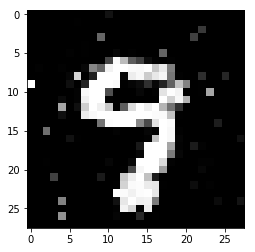

In [151]:
# print(gen_labels.shape)
# print(gen_images.shape)

# print(gen_labels[89])
# plt.imshow(gen_images[89,:,:, 0], cmap='gray')


In [152]:
print(classif.evaluate(gen_images, to_categorical(gen_labels)))

10000/10000 [==============================] - 2s 187us/step
[2.172676750946045, 0.2996]


In [140]:
# print(classif.metrics_names)

['loss', 'acc']
